In [1]:
%load_ext autoreload
%autoreload 2
import sys
import time
import datetime
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint

import qtrl

from datetime import date
from scipy import signal
from scipy.optimize import curve_fit
from pathlib import Path
from rich import print as rprint
from rich.progress import track
from tqdm import tqdm
from qcodes.instrument_drivers.Keysight.Keysight_N5241B import N5241B
from qtrl.fitting.resonator_fitting import (resonator_regression, reflection_resonator_params, resonator_f_to_S, hanger_resonator_params,)

In [2]:
try:
    vna = N5241B(name='vna1', address='TCPIP::192.168.4.231')
except KeyError as e:
    print(e)

Connected to: Keysight Technologies N5241B (serial:MY58422344, firmware:A.13.60.06) in 0.11s


In [3]:
date = datetime.date.today()
datadir = Path('data/' + str(date))
if not os.path.exists(datadir):
    os.makedirs(datadir)

In [4]:
def non_redund_fig(exp_name):
# A function to prevent figure overwrite issues
    i = 1
    fig_name = str(datadir) + f'/{device}-{qubit}-{exp_name}'
    if os.path.isfile(fig_name) is False:
        fig.savefig(fig_name)
    else:
        for os.path.isfile(fig_name + f'-{i}') is True:
            i += 1
        fig.savefig(fig_name + f'-{i}')

def non_redund_save

SyntaxError: invalid syntax (1141387990.py, line 8)

In [4]:
def update_plot(figure, new_data_x, new_data_y):
    """
    Update an existing plot with new data.

    Parameters:
        figure: matplotlib Figure object
            The figure object to update.
        new_data_x: list-like
            The x-values of the new data points.
        new_data_y: list-like
            The y-values of the new data points.
    """
    ax = figure.gca()  # Get the current axes of the figure
    ax.plot(new_data_x, new_data_y)
    figure.canvas.draw()  # Update the plot

# VNA HELPERS

In [4]:
def trace_to_df(freqs, trace):
    mlog = 20*np.log10(np.abs(trace))
    phase = np.unwrap(np.angle(trace))
    data = pd.DataFrame({'frequency': freqs, 'amplitude': mlog, 'phase': phase, 'I': np.real(trace), 'Q': np.imag(trace)})
    data = data.set_index('frequency')
    return data

def plot_trace(data):
    freqs = data.index.to_numpy()
    fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].plot(freqs/1e9, data['amplitude'])
    axes[1].plot(freqs/1e9, data['phase'])
    axes[0].set_xlim(freqs[0]/1e9, freqs[-1]/1e9)
    axes[0].set_ylabel('S21 (dB)')
    axes[1].set_ylabel('Phase (rad)')
    axes[1].set_xlabel('Frequency (GHz)')
    return fig

def vna_trace(vna, run=True):
    IQ = vna.get_complex_data(run=run)
    N = vna.points()
    freqs = np.linspace(vna.start(), vna.stop(), N)
    data = trace_to_df(freqs, IQ)
    fig = plot_trace(data)
    return fig, data

def vna_trace_no_fig(vna, run=True):
    IQ = vna.get_complex_data(run=run)
    N = vna.points()
    freqs = np.linspace(vna.start(), vna.stop(), N)
    data = trace_to_df(freqs, IQ)
    return data

def vna_port_source_power(power: float) -> None:
#simply does normal function but with the appropriate port as a kind of wrapper
    global drive_port
    if drive_port == 1:
        vna.port1.source_power(power)
    if drive_port == 2:
        vna.port2.source_power(power)

## Test

In [5]:
device = 'GKP_v0'
qubit = 'soft_gkp'
drive_port = 1 #CRITICAL TO CHANGE!
vna.two_tone_mode(two_tone_port=3, mode=False)

In [8]:
vna.electrical_delay(63.9e-9)
vna.port1.source_power(-50)
vna.points(101)
vna.averages(1)
vna.if_bandwidth(10)
vna.start(7.45*1e9)
vna.stop(7.47*1e9)

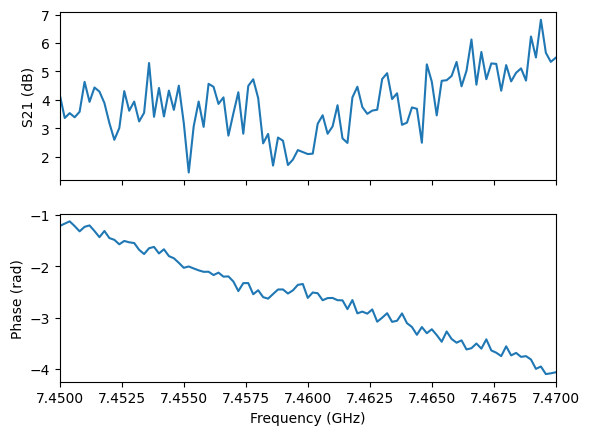

In [7]:
fig, data = vna_trace(vna, run=True)

{'a': 0.98, 'b': 2.05, 'f0': 7466640000.0, 'kappa': 1700000.0, 'kappa_int': 1300000.0, 'kappa_ext': 390000.0, 'Q': 4400.0, 'Qi': 5700.0, 'Qe': 19000.0, 'phi': -3.14, 'tau': -1.3e-07, 'a_sd': 0.032, 'b_sd': 0.039, 'f0_sd': 47000.0, 'kappa_sd': 100000.0, 'kappa_int_sd': 81000.0, 'kappa_ext_sd': 26000.0, 'Q_sd': 270.0, 'Qi_sd': 260.0, 'Qe_sd': 2700.0, 'phi_sd': 0.097, 'tau_sd': 6.8e-09}


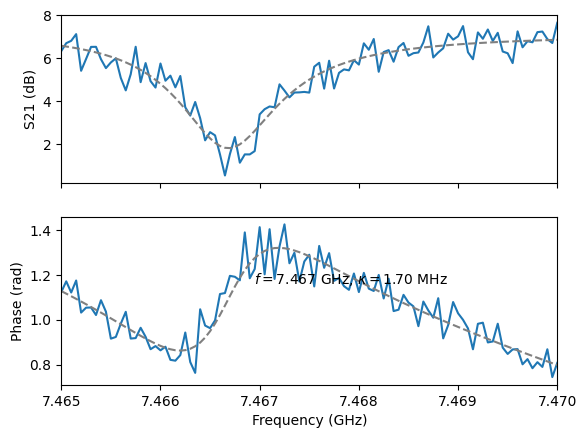

In [17]:
vna.format('PHAS')

fig, data = vna_trace(vna, run=True)
params, cov, chi = resonator_regression(data.index.to_numpy(), data['I'] + 1j*data['Q'])

# rparams = hanger_resonator_params(*params, covar=cov)
rparams = reflection_resonator_params(*params, covar=cov)
smith = resonator_f_to_S(data.index.to_numpy(), *params)
fig.axes[0].plot(data.index/1e9, 20*np.log10(np.abs(smith)), '--', color='gray')
fig.axes[1].plot(data.index/1e9, np.angle(smith), '--', color='gray')

# txt = f'$f = {rparams["f0"]/1e9:.3f}$ GHz, $\\kappa = {rparams["kappa"]/1e6:.2f}$ MHz, \n $\\ Qi = {rparams["Qi"]}$ '
txt = f'$f = {rparams["f0"]/1e9:.3f}$ GHz, $\\kappa = {rparams["kappa"]/1e6:.2f}$ MHz '

fig.axes[1].text(0.78, 0.6, txt, ha='right', transform=fig.axes[1].transAxes)
print(rparams)

# Punchout

In [25]:
qubit

'soft_gkp'

In [26]:
punchout_powers = np.linspace(-80, -10, 15)

In [27]:
punchout_powers

array([-80., -75., -70., -65., -60., -55., -50., -45., -40., -35., -30.,
       -25., -20., -15., -10.])

In [28]:
name = f'punchout_{device}-{qubit}.csv'

15it [02:19,  9.29s/it]


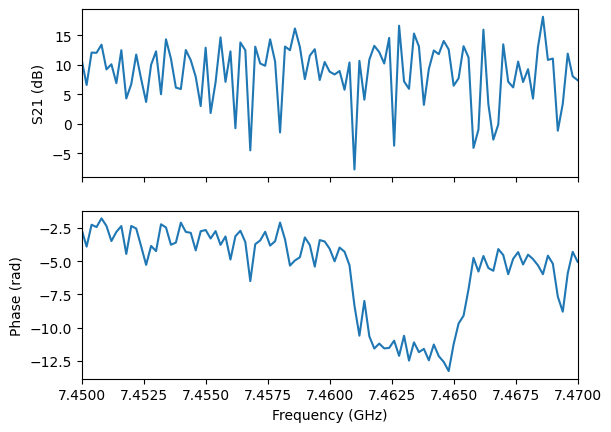

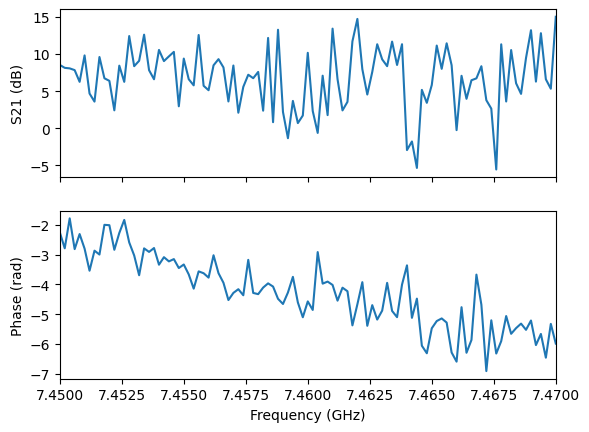

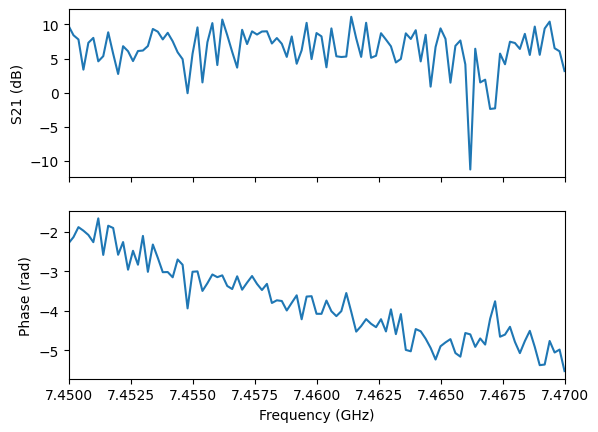

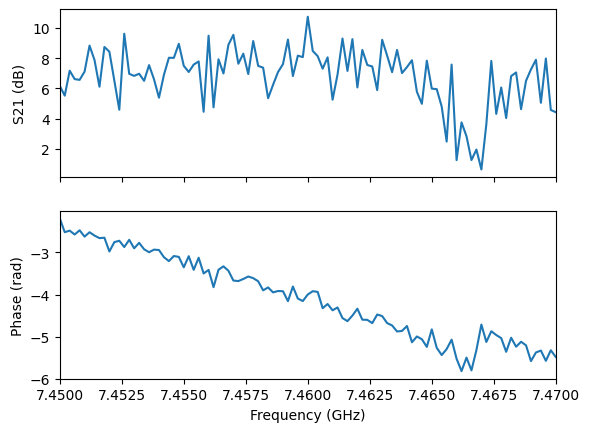

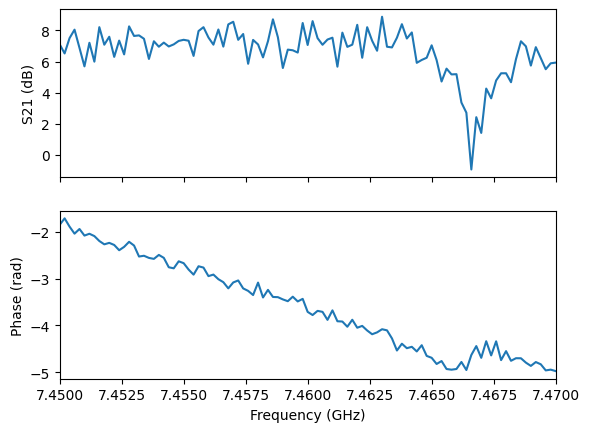

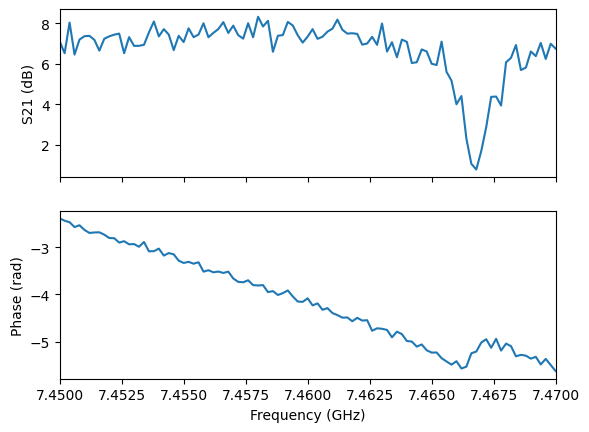

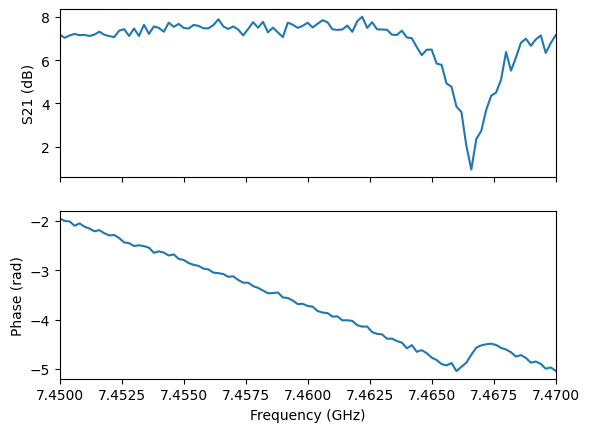

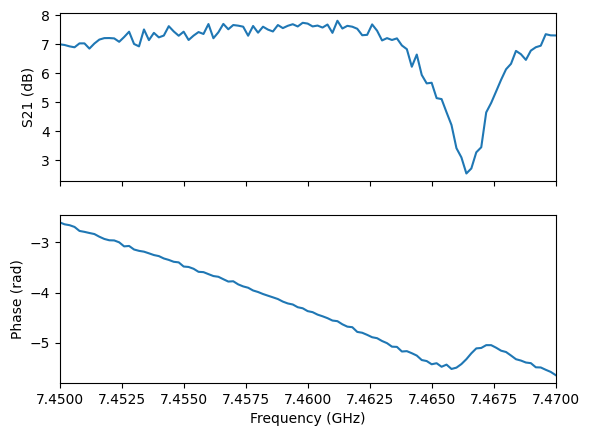

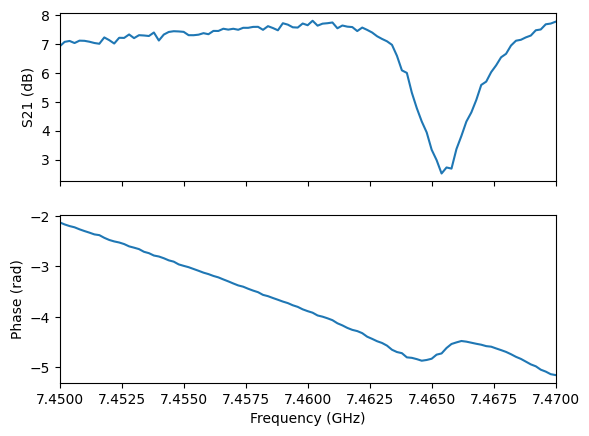

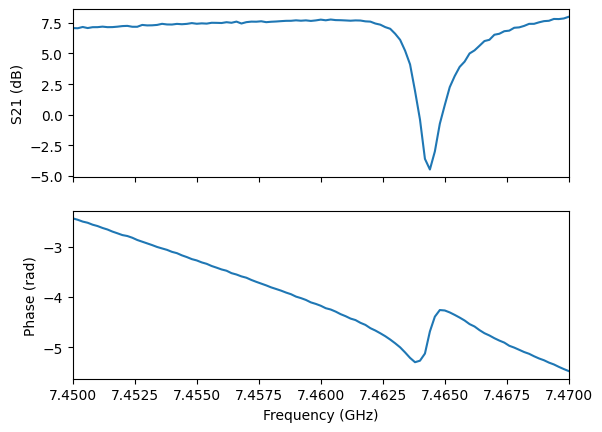

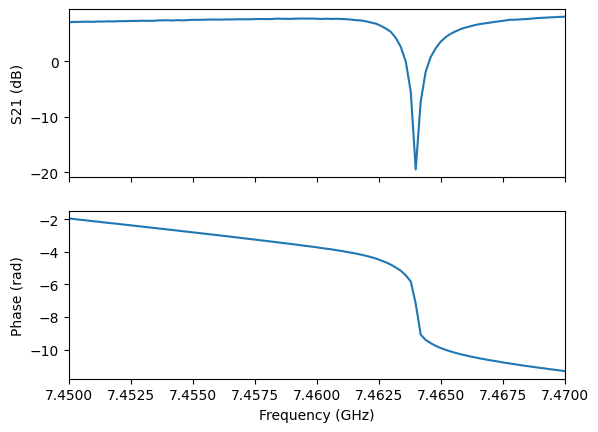

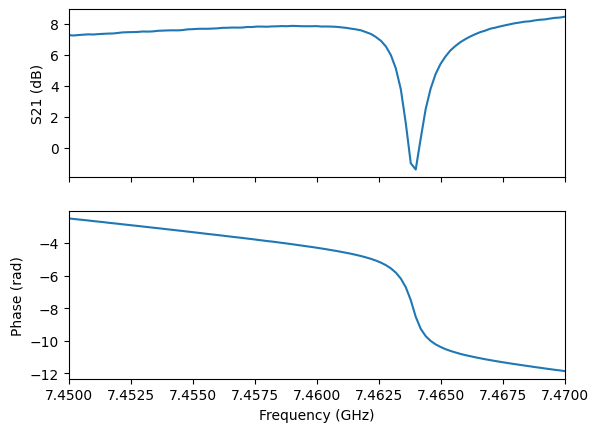

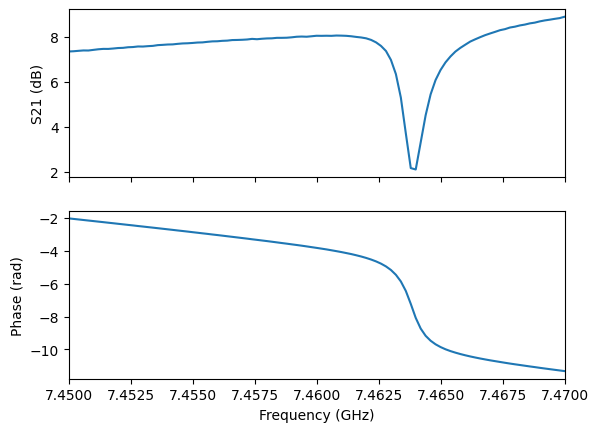

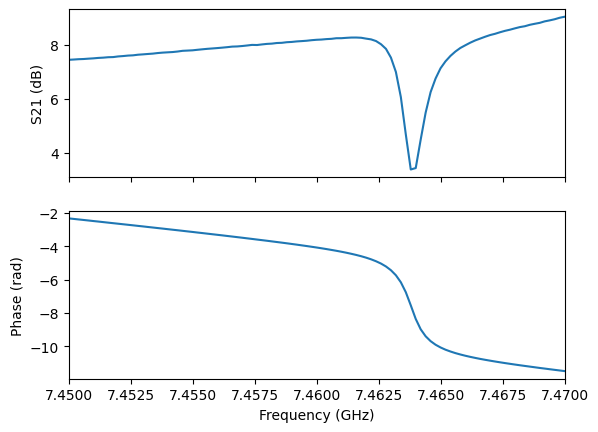

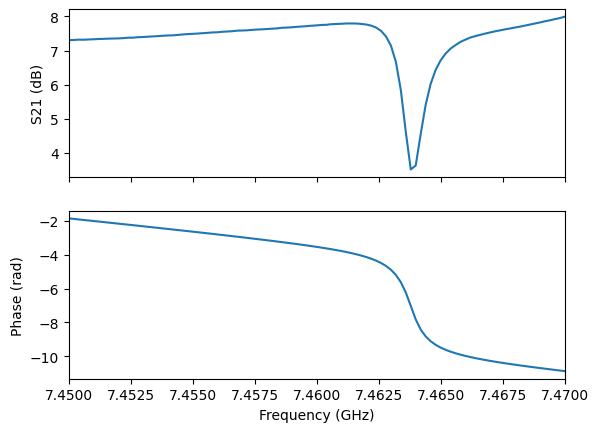

In [30]:
sweeps = []

for i, power in tqdm(enumerate(punchout_powers)):
    vna.port2.source_power(power) #MAKE SURE THIS IS ADJUSTING THE CORRECT PORT
    fig, data = vna_trace(vna, run=True)
    sweeps.append(data) # assuming frequencies are fixed throughout the punchout sweep
    
data = pd.concat(sweeps, keys=punchout_powers[:i+1], names=['power'])
data.to_csv(datadir / name)

## Plot 2D

In [365]:
# name = 'punchout_2d_dolan_fluxonium_icicle-f2.csv'
# datadir = datadir = Path('data/' + '2024-02-06')


In [31]:
punchout = pd.read_csv(datadir / name, index_col=[0, 1])

In [32]:
punchout['amplitude'].to_numpy().shape

(1515,)

In [33]:
plotting_data_amplitude = punchout['amplitude'].to_numpy().reshape((len(punchout_powers), 101))
plotting_data_phase = punchout['phase'].to_numpy().reshape((len(punchout_powers), 101))

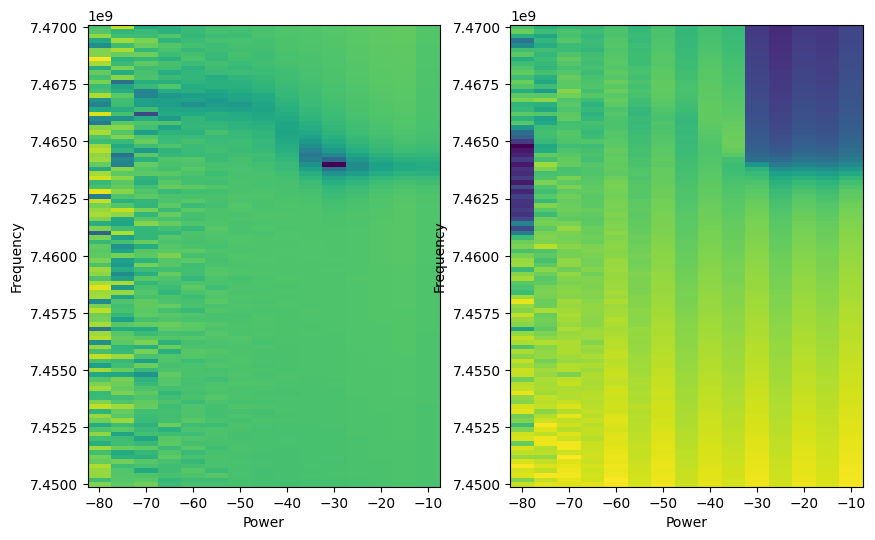

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].pcolormesh(punchout_powers, np.linspace(vna.start(), vna.stop(), vna.points()),plotting_data_amplitude.transpose())
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Frequency')
ax[1].pcolormesh(punchout_powers, np.linspace(vna.start(), vna.stop(), vna.points()),plotting_data_phase.transpose())
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Frequency')

# creates a new figure with a non-redundant name for every time it is run
fig_name = str(datadir) + f'/punchout_{device}-{qubit}'
if os.path.isfile(fig_name):
    fig.savefig(str(datadir) + f'/punchout_{device}-{qubit}_{i}')

# ax[0].set_ylim([7.45e9, 7.5e9])

# Flux Tuning

## Connect to Yoko

### Yoko

In [9]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200

In [10]:
yoko_coil = GS200(name='yoko_coil', address='TCPIP::192.168.4.208')
yoko_onchip = GS200(name='yoko_onchip', address='TCPIP::192.168.4.157')

Connected to: YOKOGAWA GS210 (serial:91PC11413, firmware:2.02) in 0.03s
Connected to: YOKOGAWA GS210 (serial:91S621541, firmware:2.02) in 0.03s


In [11]:
yoko_coil.source_mode('CURR')
yoko_onchip.source_mode('CURR')
yoko_coil.current_limit(10e-3)
yoko_coil.range(1e-3)
yoko_onchip.current_limit(10e-3)
yoko_onchip.range(1e-3)

In [12]:
yoko_coil.ramp_current(0e-3, step=1e-4, delay=0.1)
yoko_onchip.ramp_current(0e-3, step=1e-4, delay=0.1)

In [13]:
yoko_coil.on()
yoko_onchip.on()

### Measure

In [371]:
vna_port_source_power(-65)
vna.points(201),
vna.averages(1),
vna.if_bandwidth(200),
vna.start(6.86e9),
vna.stop(6.90e9)

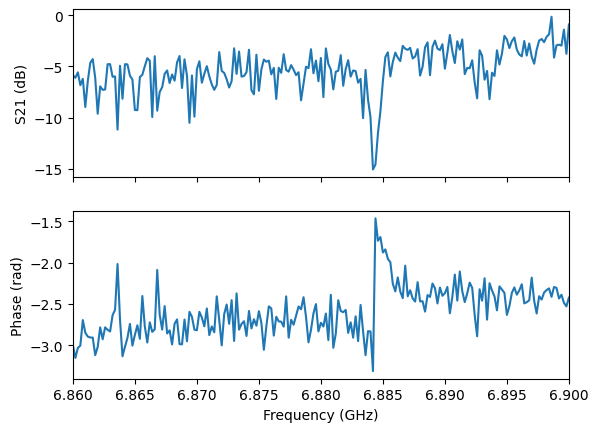

In [372]:
fig, data = vna_trace(vna, run=True)
# ax.axvline(np.linspace(vna.start(), vna.stop(), vna.points())[int(vna.points()/2)])

In [381]:
start_current = -0.5 #mA
end_current = 0.5 #mA
num_sweep = 101
name = f'{device}_{qubit}_onchip_{start_current}mAto{end_current}mA.csv'
currents = np.linspace(start_current, end_current, num_sweep) * 1e-3
yoko.current()

0.0

### Yoko Sweep

In [ ]:
start_current = -0.5 #mA
end_current = 0.5 #mA
num_sweep = 101
name = f'{device}_{qubit}_onchip_{start_current}mAto{end_current}mA.csv'
currents = np.linspace(start_current, end_current, num_sweep) * 1e-3
yoko.current()

sweeps = []
yoko.on()

for i, current in tqdm(enumerate(currents)):
    yoko.ramp_current(current, step 


In [382]:
sweeps = []

yoko.on()
for i, current in tqdm(enumerate(currents)):
    yoko.ramp_current(current, step=1e-5, delay=0.01)
    time.sleep(0.2)
    data = vna_trace_no_fig(vna, run=True)
    sweeps.append(data) # assuming frequencies are fixed throughout the punchout sweep
    
data = pd.concat(sweeps, keys=currents[:i+1], names=['power'])
data.to_csv(datadir/name)

101it [02:23,  1.42s/it]


### Plot One Tone Flux Sweep

In [383]:
flux_sweep = pd.read_csv(datadir / name, index_col=[0, 1])

In [384]:
plotting_data_flux_sweep = flux_sweep['amplitude'].to_numpy().reshape((len(currents), 201))

In [422]:
#1D flux sweep const freq
start_current = 0.5 #mA
end_current = -0.5 #mA
num_sweep = 1001
name = f'{device}_{qubit}_{start_current}mAto{end_current}mA_rev.csv'
currents = np.linspace(start_current, end_current, num_sweep) * 1e-3
yoko.current()

-0.0005

In [ ]:
vna_port_source_power(-50)
vna.points(1),
vna.averages(1),
vna.if_bandwidth(10),
vna.start(6.875e9),
vna.stop(6.875e9)

sweeps = []

yoko.on()
for i, current in tqdm(enumerate(currents)):
    yoko.ramp_current(current, step=1e-5, delay=0.01)
    time.sleep(0.1)
    data = vna_trace_no_fig(vna, run=True)
    sweeps.append(data) # assuming frequencies are fixed throughout the punchout sweep
    
data = pd.concat(sweeps, keys=currents[:i+1], names=['power'])
data.to_csv(datadir/name)

In [423]:
flux_sweep = pd.read_csv(datadir / name, index_col=[0, 1])

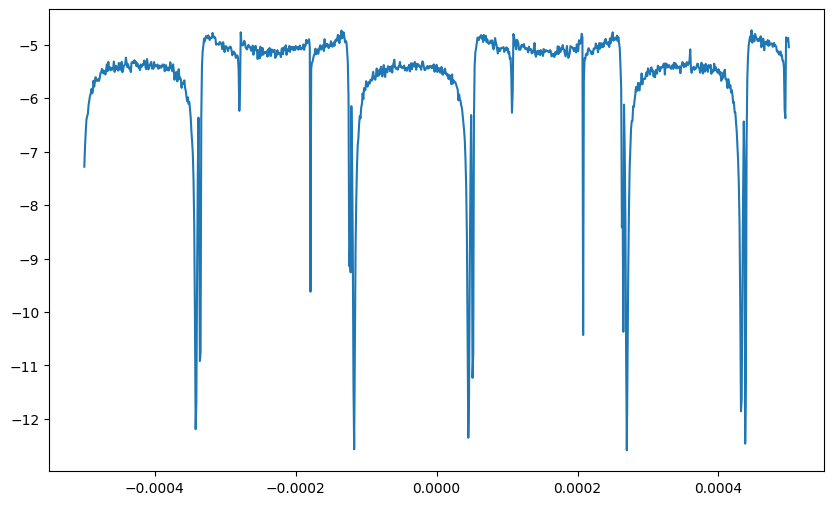

In [424]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(currents, flux_sweep['amplitude'].to_numpy().reshape((len(currents),1)))

In [425]:
fig.savefig(str(datadir) + f'/1D_flux_sweep-{device}-{qubit}-rev')

(100,)
951
[27925.1092228  27916.79137294 27911.64151946 27907.82587836
 27903.18449129 27900.46051073 27897.06786119 27893.18582066
 27888.38476166 27886.78675078 27885.85400042 27885.63614712
 27885.69963205 27886.38604662 27885.32833061 27895.12265767
 27893.97293149 27891.55456441 27888.00395478 27889.22276191
 27890.58823532 27865.8228188  27841.48777038 27817.80635069
 27800.85239968 27794.61872001 27814.47241806 27791.77730497
 27760.06862577 27675.04560712]


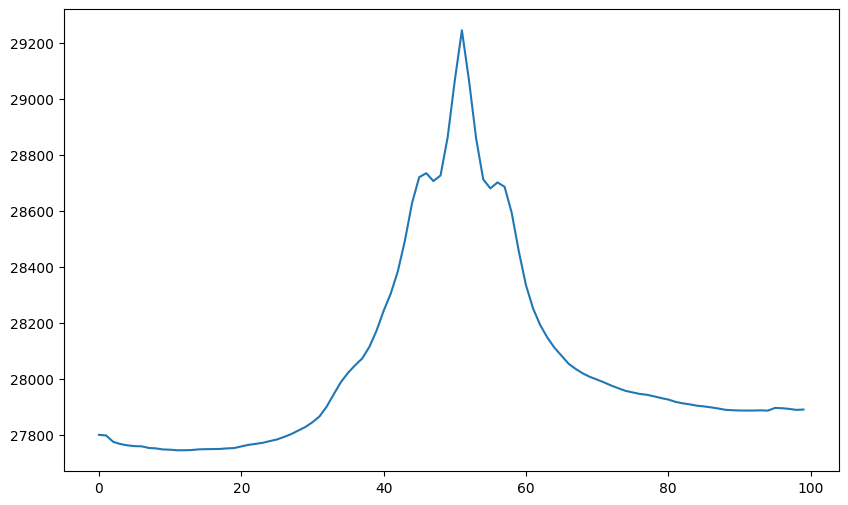

In [468]:
start_current = -0.5 #mA
end_current = 0.5 #mA
num_sweep = 1001
name = f'{device}_{qubit}_{start_current}mAto{end_current}mA_rev.csv'
flux_sweep = pd.read_csv(datadir / name, index_col=[0, 1])
flux_sweep = flux_sweep['amplitude'].to_numpy().reshape((len(currents),1)).flatten()
start_current = 0.5 #mA
end_current = -0.5 #mA
num_sweep = 1001
name = f'{device}_{qubit}_{start_current}mAto{end_current}mA_rev.csv'
flux_sweep_rev = pd.read_csv(datadir / name, index_col=[0,1])
flux_sweep_rev = flux_sweep_rev['amplitude'].to_numpy().reshape((len(currents),1)).flatten()
flux_sweep_convolve = np.convolve(flux_sweep, flux_sweep_rev[50:-50])
fig, ax = plt.subplots(figsize=(10,6))
print(np.shape(flux_sweep_convolve[900:1000]))
ax.plot(flux_sweep_convolve[900:1000])
fig.savefig(str(datadir) + f'/1D_flux_sweep-{device}-{qubit}-convolve-noedgeeffect-close')
print(np.argmax(flux_sweep_convolve))
print(flux_sweep_convolve[980:1010])

In [403]:
#1D flux sweep const freq
start_current = 0.5 #mA
end_current = -0.5 #mA
num_sweep = 1001
name = f'{device}_{qubit}_{start_current}mAto{end_current}mA_rev.csv'
currents = np.linspace(start_current, end_current, num_sweep) * 1e-3
yoko.current()

vna_port_source_power(-50)
vna.points(1),
vna.averages(1),
vna.if_bandwidth(10),
vna.start(6.875e9),
vna.stop(6.875e9)

sweeps = []

yoko.on()
for i, current in tqdm(enumerate(currents)):
    yoko.ramp_current(current, step=1e-5, delay=0.01)
    time.sleep(0.1)
    data = vna_trace_no_fig(vna, run=True)
    sweeps.append(data) # assuming frequencies are fixed throughout the punchout sweep
    
data = pd.concat(sweeps, keys=currents[:i+1], names=['power'])
data.to_csv(datadir/name)

1001it [07:07,  2.34it/s]


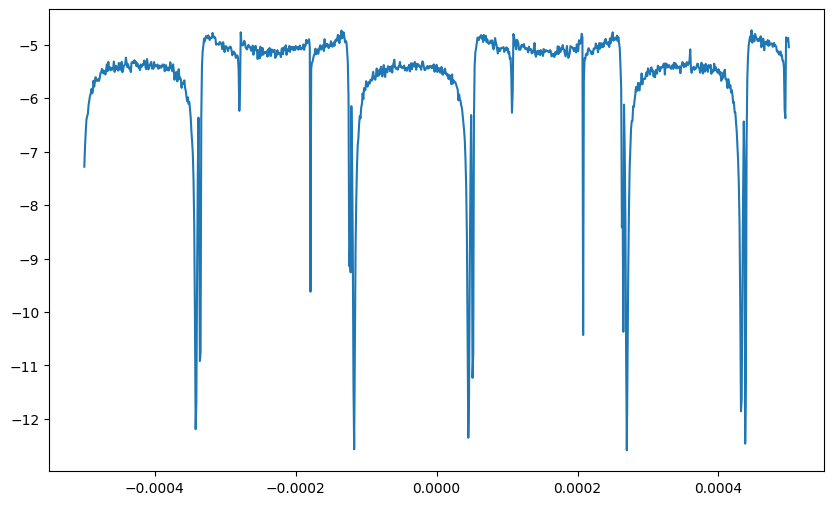

In [404]:
flux_sweep = pd.read_csv(datadir / name, index_col=[0, 1])
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(currents, flux_sweep['amplitude'].to_numpy().reshape((len(currents),1)))

In [405]:
fig.savefig(str(datadir) + f'/1D_flux_sweep_{device}-{qubit}')

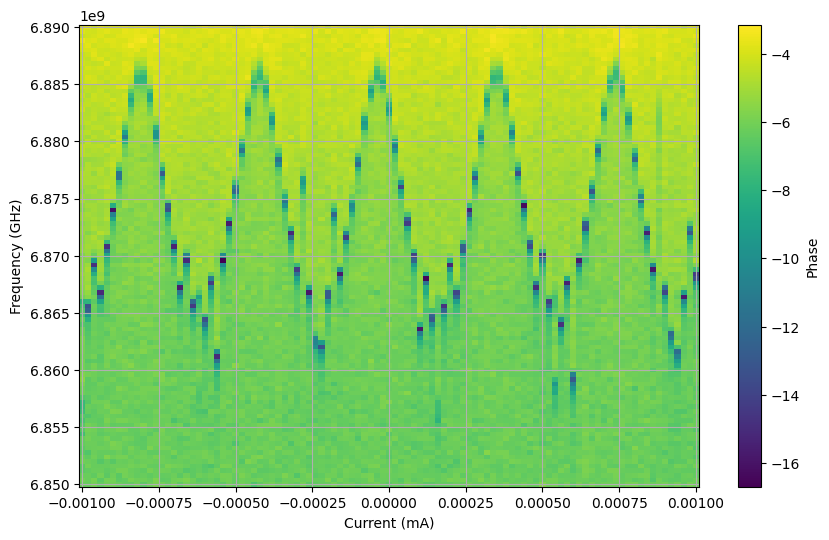

In [392]:
#a reverse sweep from 5ma to -5ma
fig, ax = plt.subplots(figsize=(10,6))
im = ax.pcolormesh(currents, np.linspace(vna.start(), vna.stop(), vna.points()), plotting_data_flux_sweep.transpose())
ax.set_xlabel('Current (A)')
ax.set_ylabel('Frequency (GHz)')
ax.grid(visible=True)
fig.colorbar(im, label="Phase")
# ax.axhline(np.linspace(vna.start(), vna.stop(), vna.points())[47], color='red')
# ax.set_ylim(np.array([7.2,7.215])*1e9)

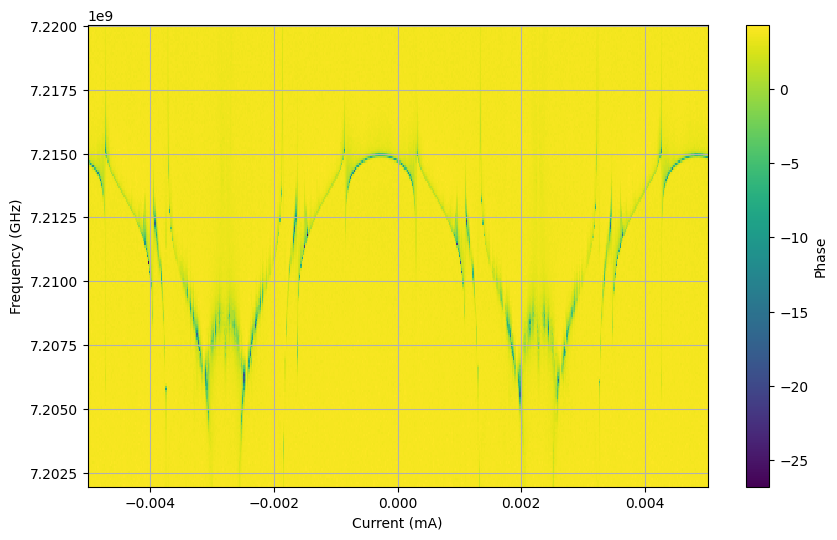

In [118]:
#a sweep from -5ma to 5ma
fig, ax = plt.subplots(figsize=(10,6))
im = ax.pcolormesh(currents, np.linspace(vna.start(), vna.stop(), vna.points()),plotting_data_flux_sweep.transpose())
ax.set_xlabel('Current (mA)')
ax.set_ylabel('Frequency (GHz)')
ax.grid(visible=True)
fig.colorbar(im, label="Phase")
# ax.axhline(np.linspace(vna.start(), vna.stop(), vna.points())[47], color='red')
# ax.set_ylim(np.array([7.2,7.215])*1e9)

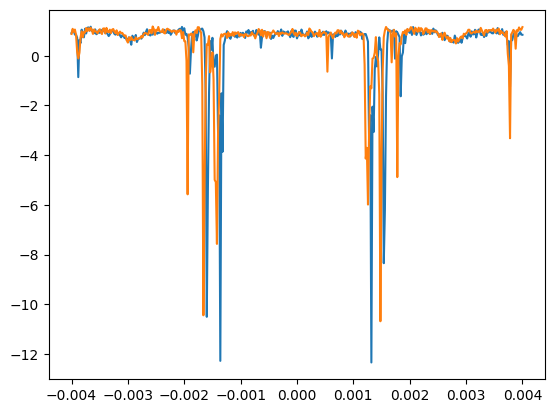

In [168]:
index = 50

plt.plot(currents[::-1], plotting_data_flux_sweep2.transpose()[index])
plt.plot(currents, plotting_data_flux_sweep.transpose()[index])

In [210]:
fig.savefig(str(datadir) + f'/flux_sweep_{device}-{qubit}')

# Two Tone

In [14]:
yoko_coil.ramp_current(-50e-6, step=1e-5, delay=0.01)
yoko_onchip.ramp_current(-415e-6, step=1e-5, delay=0.01)
yoko_coil.on()
yoko_onchip.on()

{'a': 0.54, 'b': -1.17, 'f0': 7472790000.0, 'kappa': 8090000.0, 'kappa_int': -2500000.0, 'kappa_ext': 11000000.0, 'Q': 923.0, 'Qi': -3000.0, 'Qe': 710.0, 'phi': -3.14, 'tau': 1.6e-07, 'a_sd': 0.051, 'b_sd': 0.027, 'f0_sd': 100000.0, 'kappa_sd': 160000.0, 'kappa_int_sd': 250000.0, 'kappa_ext_sd': 340000.0, 'Q_sd': 18.0, 'Qi_sd': 690.0, 'Qe_sd': 45.0, 'phi_sd': 0.028, 'tau_sd': 8.5e-09}


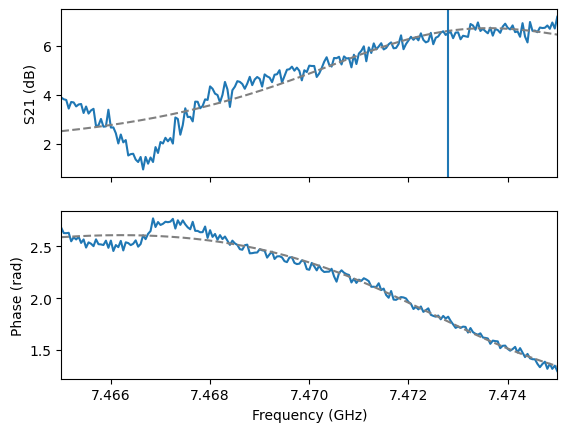

In [19]:
vna.two_tone_mode(two_tone_port=3, mode=False, frequency = 7298958000.0)

vna.start(7.465*1e9)
vna.stop(7.475*1e9)
vna.port2.source_power(-55)
vna.points(201)
vna.averages(1)
vna.if_bandwidth(10)

fig, data = vna_trace(vna, run=True)
params, cov, chi = resonator_regression(data.index.to_numpy(), data['I'] + 1j*data['Q'])
rparams = reflection_resonator_params(*params, covar=cov)
smith = resonator_f_to_S(data.index.to_numpy(), *params)
fig.axes[0].plot(data.index/1e9, 20*np.log10(np.abs(smith)), '--', color='gray')
fig.axes[1].plot(data.index/1e9, np.angle(smith), '--', color='gray')
fig.axes[0].axvline(rparams['f0']/1e9)

print(rparams)

In [20]:
min_index = data['amplitude'].idxmin()
rparams['f0'] = min_index
# print(data['frequency'])
# print(data['frequency'][min_index])
# min_row_name = data.loc[min_index, 'frequency']

In [24]:
two_tone_start = 0.01*1e9
two_tone_end = 7.3*1e9
two_tone_power = 10
two_tone_points = 1458*1+1

In [22]:
vna.ports[2]

<PNAPort: vna1_port3 of N5241B: vna1>

In [26]:
#vna.two_tone_mode(two_tone_port=3, mode=True, frequency = rparams['f0'])
# powers = np.linspace(-50,-10, 9)
power = 10
# for power in powers:
vna.port2.source_power(-55),
vna.if_bandwidth(20)
vna.points(two_tone_points)
vna.start(two_tone_start)
vna.stop(two_tone_end)
vna.averages(10)
vna.ports[2].source_power(power)
vna.two_tone_mode(two_tone_port=3, mode=True, frequency = rparams['f0'])
fig, data = vna_trace(vna, run=True)


KeyboardInterrupt



### single sweeps

In [27]:
onchip_currents = np.linspace(-415, 561, int(976/4) + 1) * 1e-6
coil_currents = (-16/976)*(onchip_currents-2.91e-4)-6.15e-5

current_step = 1e-4

# yoko_coil.ramp_current(0e-3, step=1e-4, delay=0.1)
# yoko_onchip.ramp_current(0e-3, step=1e-4, delay=0.1)
yoko_coil.on()
yoko_onchip.on()

two_tone_start = 0.01*1e9
two_tone_end = 7.3*1e9
two_tone_power = 10
two_tone_points = 1459

In [28]:
print(onchip_currents)
# print(coil_currents)

[-4.15e-04 -4.11e-04 -4.07e-04 -4.03e-04 -3.99e-04 -3.95e-04 -3.91e-04
 -3.87e-04 -3.83e-04 -3.79e-04 -3.75e-04 -3.71e-04 -3.67e-04 -3.63e-04
 -3.59e-04 -3.55e-04 -3.51e-04 -3.47e-04 -3.43e-04 -3.39e-04 -3.35e-04
 -3.31e-04 -3.27e-04 -3.23e-04 -3.19e-04 -3.15e-04 -3.11e-04 -3.07e-04
 -3.03e-04 -2.99e-04 -2.95e-04 -2.91e-04 -2.87e-04 -2.83e-04 -2.79e-04
 -2.75e-04 -2.71e-04 -2.67e-04 -2.63e-04 -2.59e-04 -2.55e-04 -2.51e-04
 -2.47e-04 -2.43e-04 -2.39e-04 -2.35e-04 -2.31e-04 -2.27e-04 -2.23e-04
 -2.19e-04 -2.15e-04 -2.11e-04 -2.07e-04 -2.03e-04 -1.99e-04 -1.95e-04
 -1.91e-04 -1.87e-04 -1.83e-04 -1.79e-04 -1.75e-04 -1.71e-04 -1.67e-04
 -1.63e-04 -1.59e-04 -1.55e-04 -1.51e-04 -1.47e-04 -1.43e-04 -1.39e-04
 -1.35e-04 -1.31e-04 -1.27e-04 -1.23e-04 -1.19e-04 -1.15e-04 -1.11e-04
 -1.07e-04 -1.03e-04 -9.90e-05 -9.50e-05 -9.10e-05 -8.70e-05 -8.30e-05
 -7.90e-05 -7.50e-05 -7.10e-05 -6.70e-05 -6.30e-05 -5.90e-05 -5.50e-05
 -5.10e-05 -4.70e-05 -4.30e-05 -3.90e-05 -3.50e-05 -3.10e-05 -2.70e-05
 -2.30

In [ ]:
sweeps = []

for i, onchip_current in tqdm(enumerate(onchip_currents)):
    coil_current = coil_currents[i]
    print(f"Current is: onchip:{onchip_current}")
    print(f"Current is: coil:{coil_current}")
    yoko_onchip.ramp_current(onchip_current, step=current_step, delay=0.1)
    yoko_coil.ramp_current(coil_current, step=current_step, delay=0.1)
    time.sleep(3)
    
    ### Fit resonator
    vna.two_tone_mode(two_tone_port=3, mode=False, frequency = 7298958000.0)
    vna.start(7.46*1e9)
    vna.stop(7.475*1e9)
    vna.port2.source_power(-55)
    vna.points(151)
    vna.averages(3)
    vna.if_bandwidth(10)
    fig, data = vna_trace(vna, run=True)
    
    # params, cov, chi = resonator_regression(data.index.to_numpy(), data['I'] + 1j*data['Q'])
    # rparams = reflection_resonator_params(*params, covar=cov)
    # smith = resonator_f_to_S(data.index.to_numpy(), *params)
    # fig.axes[0].plot(data.index/1e9, 20*np.log10(np.abs(smith)), '--', color='gray')
    # fig.axes[1].plot(data.index/1e9, np.angle(smith), '--', color='gray')
    # fig.axes[0].axvline(rparams['f0']/1e9)
    # res_freq = rparams['f0']/1e9

    res_freq = data['amplitude'].idxmin()
    print(f'Resonator frequency is: {res_freq} GHz')

    ### Perform Two Tone       
    vna.two_tone_mode(two_tone_port=3, mode=True, frequency = res_freq)
    vna.if_bandwidth(10)
    vna.points(two_tone_points)
    vna.start(two_tone_start)
    vna.stop(two_tone_end)
    vna.averages(3)
    vna.ports[2].source_power(two_tone_power)

    try:
        swp = vna_trace_no_fig(vna, run=True)
    except:
        try:
            print('Error')
            time.sleep(3)
            swp = vna_trace_no_fig(vna, run=False)
        except:
            print(f'Still error on {i}')

    sweeps += [swp]

name = str(date.today()) + f'_{device}_{qubit}-current_sweep_{two_tone_start}to{two_tone_end}GHz_{two_tone_power}dbm_avg3.csv'
data = pd.concat(sweeps, keys=coil_currents[:i+1], names=['Current'])
data.to_csv(datadir / name)

0it [00:00, ?it/s]

Current is: onchip:-0.000415
Current is: coil:-4.9926229508196725e-05
Resonator frequency is: 7466600000.0 GHz


In [133]:
name = str(date.today()) + f'_{device}_{qubit}-current_sweep_{two_tone_start}to{two_tone_end}GHz_{two_tone_power}dbm.csv'
data = pd.concat(sweeps, keys=coil_currents[:i+1], names=['Current'])
data.to_csv(datadir / name)

In [134]:
data1 = pd.concat(sweeps, keys = onchip_currents, names=['onchip_current'])

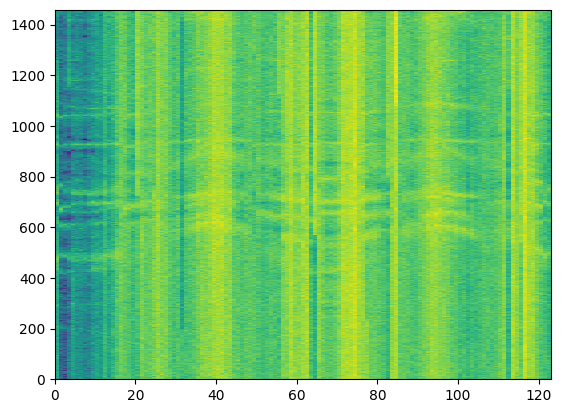

In [192]:
plotting_two_tone_data = np.array(data['amplitude'][:]).reshape((123,1459)).transpose()
plt.pcolormesh(plotting_two_tone_data)

In [188]:
two_tone_plot = np.array(data['amplitude'][:]).reshape((123,1459)).transpose()
normalized_data = []
for i, column in enumerate(two_tone_plot.transpose()):
    column = (column - np.mean(column))/np.std(column)
    normalized_data.append(column)
# normalized_data = np.subtract(two_tone_plot-mean_vals, axis=1)/std_vals
normalized_data = np.asarray(normalized_data).transpose()

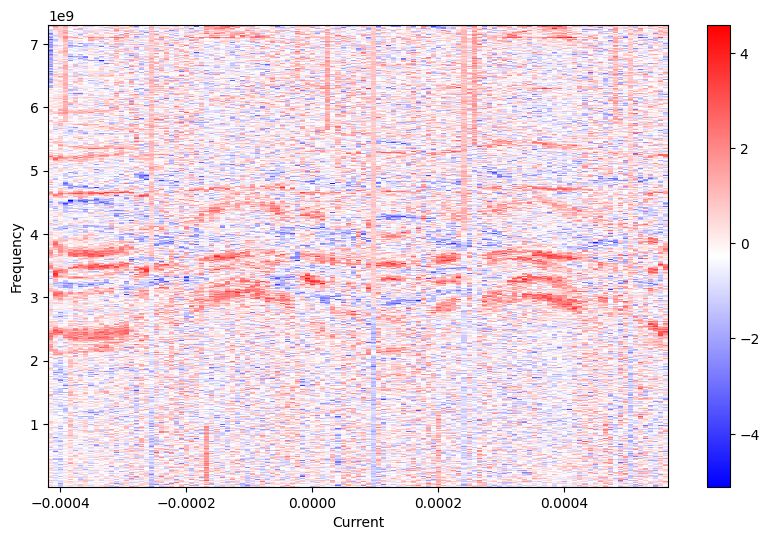

In [201]:
fig, ax = plt.subplots(figsize=(10,6))
im = ax.pcolormesh(onchip_currents, np.linspace(two_tone_start, two_tone_end, two_tone_points), normalized_data, cmap='bwr')
ax.set_xlabel('Current')
ax.set_ylabel('Frequency')
fig.colorbar(im)

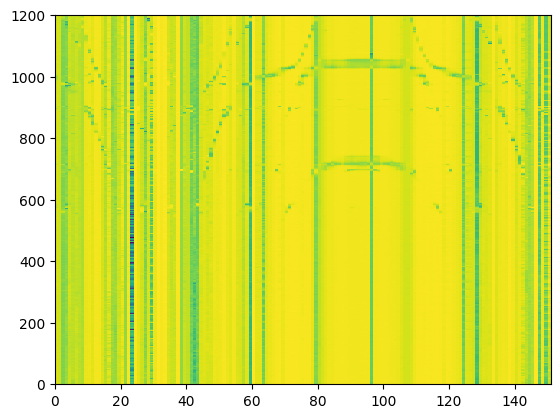

In [220]:
plt.pcolormesh(np.array(data1['amplitude'][:]).reshape((151,1201)).transpose())

## Plot Two Tone Data

In [450]:
name = str(date.today()) + f'_{device}_{qubit}-current_sweep_{two_tone_start}to{two_tone_end}GHz_{two_tone_power}dbm.csv'
data = pd.concat(sweeps, keys=coil_currents[:i+1], names=['Current'])
data.to_csv(datadir / name)

In [222]:
two_tone_sweep = pd.read_csv(datadir / name, index_col=[0, 1])

In [224]:
plotting_data_two_tone_sweep = two_tone_sweep['amplitude'].to_numpy().reshape((151, two_tone_points))

In [180]:
#plotting_data_two_tone_sweep = two_tone_sweep['amplitude'].to_numpy().reshape((len(coil_currents), two_tone_points))

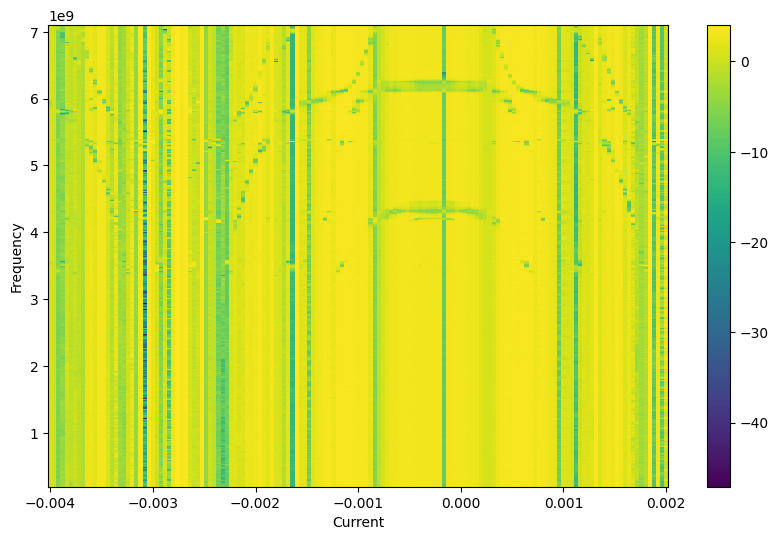

In [227]:
fig, ax = plt.subplots(figsize=(10,6))
im = ax.pcolormesh(coil_currents[:151], np.linspace(two_tone_start, two_tone_end, two_tone_points), plotting_data_two_tone_sweep.transpose()
#              , vmin=-20, vmax=10
             )
ax.set_xlabel('Current')
ax.set_ylabel('Frequency')

fig.colorbar(im)


### Better Visibility

In [228]:
plotting_data_two_tone_sweep = np.array(two_tone_sweep['phase']).reshape((151,two_tone_points))

In [162]:
better_data = []

for column in plotting_two_tone_data:
#     row = np.unwrap(row)
    new_column = (row-np.median(column))/ abs(np.median(column))
    better_data.append(column)
    
better_data = np.array(np.transpose(better_data))

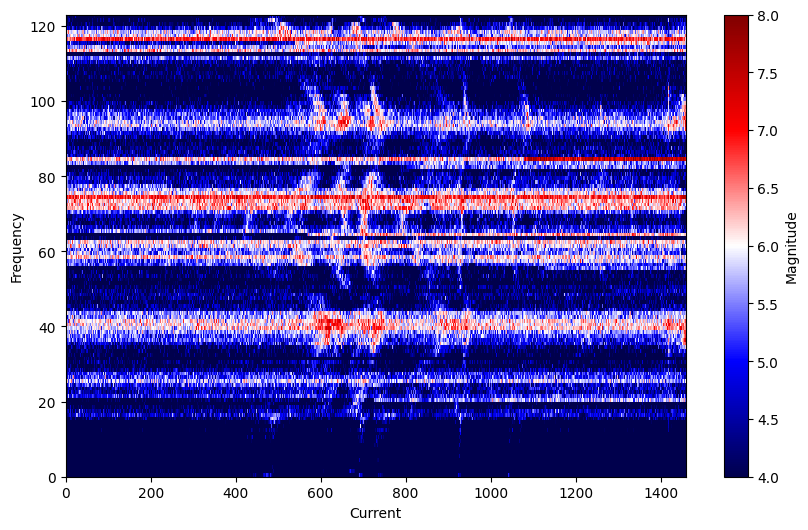

In [165]:
fig, ax = plt.subplots(figsize=(10,6))
im = ax.pcolormesh(better_data, cmap='seismic'
                   , vmin=4, vmax=8
                  )
ax.set_xlabel('Current')
ax.set_ylabel('Frequency')
fig.colorbar(im, label = "Magnitude")
# ax.set_ylim([7.2*1e9, 10.0*1e9])

(5000000000.0, 10000000000.0)

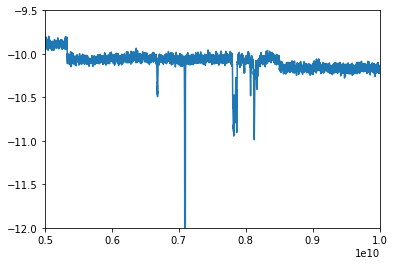

In [76]:
plt.plot(np.linspace(2.0*1e9, 10.0*1e9, 10001), plotting_data_two_tone_sweep[80])
plt.ylim([-12, -9.5])
plt.xlim([5e9, 10e9])

# Dual Flux Sweeps

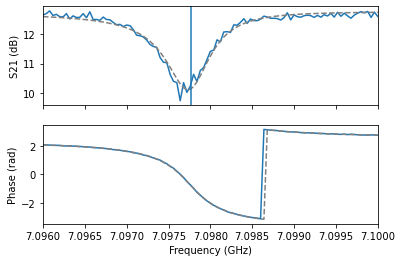

In [606]:
vna.two_tone_mode(two_tone_port=3, mode=False, frequency = 7298958000.0)



vna.start(start)
vna.stop(stop)
vna.port1.source_power(-50)
vna.points(101)
vna.averages(1)
vna.if_bandwidth(10)


fig, data = vna_trace(vna, run=True)

params, cov, chi = resonator_regression(data.index.to_numpy(), data['I'] + 1j*data['Q'])

    
rparams = reflection_resonator_params(*params, covar=cov)
smith = resonator_f_to_S(data.index.to_numpy(), *params)
fig.axes[0].plot(data.index/1e9, 20*np.log10(np.abs(smith)), '--', color='gray')
fig.axes[1].plot(data.index/1e9, np.angle(smith), '--', color='gray')

fig.axes[0].axvline(rparams['f0']/1e9)

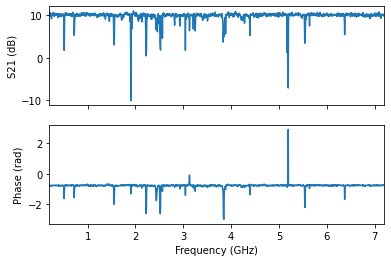

In [607]:
two_tone_start = 0.2*1e9
two_tone_end = 7.2*1e9
two_tone_power = 0
two_tone_points = 1401

vna.two_tone_mode(two_tone_port=3, mode=True, frequency = rparams['f0'])
vna.if_bandwidth(15)
vna.points(two_tone_points)
vna.start(two_tone_start)
vna.stop(two_tone_end)
vna.ports[2].source_power(two_tone_power)

fig, data = vna_trace(vna, run=True)


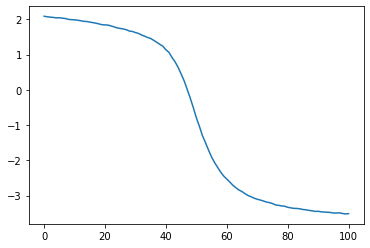

In [520]:
plt.plot(np.unwrap(data['phase']))

In [608]:
num_currents=201

In [609]:
coil_currents =  np.linspace(0, 44, num_currents) * 1e-6

In [610]:
coil_currents

array([0.000e+00, 2.200e-07, 4.400e-07, 6.600e-07, 8.800e-07, 1.100e-06,
       1.320e-06, 1.540e-06, 1.760e-06, 1.980e-06, 2.200e-06, 2.420e-06,
       2.640e-06, 2.860e-06, 3.080e-06, 3.300e-06, 3.520e-06, 3.740e-06,
       3.960e-06, 4.180e-06, 4.400e-06, 4.620e-06, 4.840e-06, 5.060e-06,
       5.280e-06, 5.500e-06, 5.720e-06, 5.940e-06, 6.160e-06, 6.380e-06,
       6.600e-06, 6.820e-06, 7.040e-06, 7.260e-06, 7.480e-06, 7.700e-06,
       7.920e-06, 8.140e-06, 8.360e-06, 8.580e-06, 8.800e-06, 9.020e-06,
       9.240e-06, 9.460e-06, 9.680e-06, 9.900e-06, 1.012e-05, 1.034e-05,
       1.056e-05, 1.078e-05, 1.100e-05, 1.122e-05, 1.144e-05, 1.166e-05,
       1.188e-05, 1.210e-05, 1.232e-05, 1.254e-05, 1.276e-05, 1.298e-05,
       1.320e-05, 1.342e-05, 1.364e-05, 1.386e-05, 1.408e-05, 1.430e-05,
       1.452e-05, 1.474e-05, 1.496e-05, 1.518e-05, 1.540e-05, 1.562e-05,
       1.584e-05, 1.606e-05, 1.628e-05, 1.650e-05, 1.672e-05, 1.694e-05,
       1.716e-05, 1.738e-05, 1.760e-05, 1.782e-05, 

In [611]:
dc_currents = np.linspace(2, 602, num_currents) * 1e-6

In [612]:
dc_currents

array([2.00e-06, 5.00e-06, 8.00e-06, 1.10e-05, 1.40e-05, 1.70e-05,
       2.00e-05, 2.30e-05, 2.60e-05, 2.90e-05, 3.20e-05, 3.50e-05,
       3.80e-05, 4.10e-05, 4.40e-05, 4.70e-05, 5.00e-05, 5.30e-05,
       5.60e-05, 5.90e-05, 6.20e-05, 6.50e-05, 6.80e-05, 7.10e-05,
       7.40e-05, 7.70e-05, 8.00e-05, 8.30e-05, 8.60e-05, 8.90e-05,
       9.20e-05, 9.50e-05, 9.80e-05, 1.01e-04, 1.04e-04, 1.07e-04,
       1.10e-04, 1.13e-04, 1.16e-04, 1.19e-04, 1.22e-04, 1.25e-04,
       1.28e-04, 1.31e-04, 1.34e-04, 1.37e-04, 1.40e-04, 1.43e-04,
       1.46e-04, 1.49e-04, 1.52e-04, 1.55e-04, 1.58e-04, 1.61e-04,
       1.64e-04, 1.67e-04, 1.70e-04, 1.73e-04, 1.76e-04, 1.79e-04,
       1.82e-04, 1.85e-04, 1.88e-04, 1.91e-04, 1.94e-04, 1.97e-04,
       2.00e-04, 2.03e-04, 2.06e-04, 2.09e-04, 2.12e-04, 2.15e-04,
       2.18e-04, 2.21e-04, 2.24e-04, 2.27e-04, 2.30e-04, 2.33e-04,
       2.36e-04, 2.39e-04, 2.42e-04, 2.45e-04, 2.48e-04, 2.51e-04,
       2.54e-04, 2.57e-04, 2.60e-04, 2.63e-04, 2.66e-04, 2.69e

In [564]:
yoko.ramp_current(coil_currents[0], step=coil_step*10, delay=0.3)
yoko2.ramp_current(dc_currents[0], step=dc_step*10, delay=0.3)

In [613]:
coil_step = 1e-6
dc_step = 10e-6

In [614]:
two_tone_power = 0

0it [00:00, ?it/s]

Current is: coil:0.0, dc:2e-06
Resonator frequency is: 7.0978673 GHz


1it [01:51, 111.12s/it]

Current is: coil:2.1999999999999998e-07, dc:4.9999999999999996e-06
Resonator frequency is: 7.0978443 GHz


2it [03:26, 102.07s/it]

Current is: coil:4.3999999999999997e-07, dc:8e-06
Resonator frequency is: 7.097725 GHz


3it [05:02, 99.15s/it] 

Current is: coil:6.6e-07, dc:1.1e-05
Resonator frequency is: 7.097807 GHz


4it [06:38, 97.76s/it]

Current is: coil:8.799999999999999e-07, dc:1.4e-05
Resonator frequency is: 7.0978055 GHz


5it [08:13, 96.99s/it]

Current is: coil:1.1e-06, dc:1.7e-05
Resonator frequency is: 7.0977872 GHz


6it [09:49, 96.53s/it]

Current is: coil:1.32e-06, dc:1.9999999999999998e-05
Resonator frequency is: 7.0977069 GHz


7it [11:25, 96.27s/it]

Current is: coil:1.5399999999999999e-06, dc:2.3e-05
Resonator frequency is: 7.0976178 GHz


8it [13:00, 96.06s/it]

Current is: coil:1.7599999999999999e-06, dc:2.6e-05
Resonator frequency is: 7.0974581 GHz


9it [14:36, 95.94s/it]

Current is: coil:1.98e-06, dc:2.9e-05
Resonator frequency is: 7.097346 GHz


10it [16:12, 95.83s/it]

Current is: coil:2.2e-06, dc:3.2e-05
Resonator frequency is: 7.09684 GHz


11it [17:47, 95.77s/it]

Current is: coil:2.4199999999999997e-06, dc:3.5e-05
Resonator frequency is: 7.09578 GHz


12it [19:23, 95.74s/it]

Current is: coil:2.64e-06, dc:3.7999999999999995e-05
Resonator frequency is: 7.10035 GHz


13it [20:59, 95.72s/it]

Current is: coil:2.8599999999999997e-06, dc:4.1e-05
Resonator frequency is: 7.099012 GHz


14it [22:34, 95.69s/it]

Current is: coil:3.0799999999999997e-06, dc:4.4e-05
Resonator frequency is: 7.098826 GHz


15it [24:10, 95.69s/it]

Current is: coil:3.2999999999999997e-06, dc:4.7e-05
Resonator frequency is: 7.098666 GHz


16it [25:45, 95.67s/it]

Current is: coil:3.5199999999999998e-06, dc:4.9999999999999996e-05
Resonator frequency is: 7.098517 GHz


17it [27:21, 95.65s/it]

Current is: coil:3.74e-06, dc:5.3e-05
Resonator frequency is: 7.098449 GHz


18it [28:57, 95.64s/it]

Current is: coil:3.96e-06, dc:5.6e-05
Resonator frequency is: 7.098354 GHz


19it [30:32, 95.68s/it]

Current is: coil:4.18e-06, dc:5.9e-05
Resonator frequency is: 7.098286 GHz


20it [32:08, 95.66s/it]

Current is: coil:4.4e-06, dc:6.2e-05


C:\Users\qnl\AppData\Local\Continuum\anaconda3\envs\parametric\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


Resonator frequency is: 7.097518 GHz


21it [33:44, 95.67s/it]

Current is: coil:4.62e-06, dc:6.5e-05
Resonator frequency is: 7.097743 GHz


22it [35:19, 95.64s/it]

Current is: coil:4.839999999999999e-06, dc:6.8e-05
Resonator frequency is: 7.097846 GHz


23it [36:55, 95.66s/it]

Current is: coil:5.059999999999999e-06, dc:7.099999999999999e-05
Resonator frequency is: 7.097871 GHz


24it [38:31, 95.65s/it]

Current is: coil:5.28e-06, dc:7.4e-05
Resonator frequency is: 7.097855 GHz


25it [40:06, 95.66s/it]

Current is: coil:5.5e-06, dc:7.7e-05
Resonator frequency is: 7.097767 GHz


26it [41:42, 95.67s/it]

Current is: coil:5.7199999999999994e-06, dc:7.999999999999999e-05
Resonator frequency is: 7.097762 GHz


27it [43:18, 95.69s/it]

Current is: coil:5.94e-06, dc:8.3e-05
Resonator frequency is: 7.098059 GHz


28it [44:54, 95.76s/it]

Current is: coil:6.1599999999999995e-06, dc:8.599999999999999e-05
Resonator frequency is: 7.098014 GHz


29it [46:29, 95.72s/it]

Current is: coil:6.38e-06, dc:8.9e-05
Resonator frequency is: 7.09804 GHz


30it [48:05, 95.69s/it]

Current is: coil:6.5999999999999995e-06, dc:9.2e-05
Resonator frequency is: 7.097192 GHz


31it [49:41, 95.66s/it]

Current is: coil:6.82e-06, dc:9.499999999999999e-05
Resonator frequency is: 7.097794 GHz


32it [51:16, 95.66s/it]

Current is: coil:7.0399999999999995e-06, dc:9.8e-05
Resonator frequency is: 7.097746 GHz


33it [52:52, 95.63s/it]

Current is: coil:7.259999999999999e-06, dc:0.000101
Resonator frequency is: 7.097517 GHz


34it [54:27, 95.65s/it]

Current is: coil:7.48e-06, dc:0.000104
Resonator frequency is: 7.09794 GHz


35it [56:03, 95.67s/it]

Current is: coil:7.699999999999999e-06, dc:0.000107
Resonator frequency is: 7.098 GHz


36it [57:39, 95.66s/it]

Current is: coil:7.92e-06, dc:0.00010999999999999999
Resonator frequency is: 7.097575 GHz


37it [59:15, 95.74s/it]

Current is: coil:8.14e-06, dc:0.000113
Resonator frequency is: 7.09795 GHz


38it [1:00:50, 95.72s/it]

Current is: coil:8.36e-06, dc:0.000116
Resonator frequency is: 7.097925 GHz


39it [1:02:26, 95.68s/it]

Current is: coil:8.58e-06, dc:0.00011899999999999999
Resonator frequency is: 7.097919 GHz


40it [1:04:02, 95.67s/it]

Current is: coil:8.8e-06, dc:0.000122
Resonator frequency is: 7.097947 GHz


41it [1:05:37, 95.69s/it]

Current is: coil:9.019999999999998e-06, dc:0.000125
Resonator frequency is: 7.097929 GHz


42it [1:07:13, 95.67s/it]

Current is: coil:9.24e-06, dc:0.000128
Resonator frequency is: 7.097933 GHz


43it [1:08:49, 95.64s/it]

Current is: coil:9.460000000000001e-06, dc:0.00013099999999999999
Resonator frequency is: 7.0979 GHz


44it [1:10:24, 95.60s/it]

Current is: coil:9.679999999999999e-06, dc:0.000134
Resonator frequency is: 7.0978902 GHz


45it [1:12:00, 95.60s/it]

Current is: coil:9.9e-06, dc:0.000137
Resonator frequency is: 7.0978731 GHz


46it [1:13:36, 95.67s/it]

Current is: coil:1.0119999999999998e-05, dc:0.00014
Resonator frequency is: 7.097857 GHz


47it [1:15:11, 95.67s/it]

Current is: coil:1.034e-05, dc:0.000143
Resonator frequency is: 7.0978356 GHz


48it [1:16:47, 95.68s/it]

Current is: coil:1.056e-05, dc:0.000146
Resonator frequency is: 7.0977911 GHz


49it [1:18:23, 95.66s/it]

Current is: coil:1.0779999999999998e-05, dc:0.000149
Resonator frequency is: 7.097774 GHz


50it [1:19:58, 95.66s/it]

Current is: coil:1.1e-05, dc:0.00015199999999999998
Resonator frequency is: 7.097734 GHz


51it [1:21:34, 95.64s/it]

Current is: coil:1.122e-05, dc:0.000155
Resonator frequency is: 7.097742 GHz


52it [1:23:09, 95.65s/it]

Current is: coil:1.1439999999999999e-05, dc:0.000158
Resonator frequency is: 7.097713 GHz


53it [1:24:45, 95.65s/it]

Current is: coil:1.166e-05, dc:0.00016099999999999998
Resonator frequency is: 7.097768 GHz


54it [1:26:21, 95.63s/it]

Current is: coil:1.188e-05, dc:0.000164
Resonator frequency is: 7.0977865 GHz


55it [1:27:56, 95.62s/it]

Current is: coil:1.21e-05, dc:0.000167
Resonator frequency is: 7.0978199 GHz


56it [1:29:32, 95.61s/it]

Current is: coil:1.2319999999999999e-05, dc:0.00016999999999999999
Resonator frequency is: 7.0978501 GHz


57it [1:31:07, 95.59s/it]

Current is: coil:1.254e-05, dc:0.000173
Resonator frequency is: 7.0978631 GHz


58it [1:32:43, 95.59s/it]

Current is: coil:1.276e-05, dc:0.000176
Resonator frequency is: 7.0978737 GHz


59it [1:34:19, 95.60s/it]

Current is: coil:1.298e-05, dc:0.000179
Resonator frequency is: 7.097843 GHz


60it [1:35:54, 95.64s/it]

Current is: coil:1.3199999999999999e-05, dc:0.00018199999999999998
Resonator frequency is: 7.0978704 GHz


61it [1:37:30, 95.62s/it]

Current is: coil:1.3419999999999999e-05, dc:0.000185
Resonator frequency is: 7.0978592 GHz


62it [1:39:05, 95.61s/it]

Current is: coil:1.364e-05, dc:0.000188
Resonator frequency is: 7.0978712 GHz


63it [1:40:41, 95.62s/it]

Current is: coil:1.386e-05, dc:0.00019099999999999998
Resonator frequency is: 7.0978861 GHz


64it [1:42:17, 95.66s/it]

Current is: coil:1.4079999999999999e-05, dc:0.000194
Resonator frequency is: 7.097831 GHz


65it [1:43:52, 95.65s/it]

Current is: coil:1.43e-05, dc:0.000197
Resonator frequency is: 7.097879 GHz


66it [1:45:28, 95.64s/it]

Current is: coil:1.4519999999999998e-05, dc:0.00019999999999999998
Resonator frequency is: 7.097873 GHz


67it [1:47:04, 95.68s/it]

Current is: coil:1.474e-05, dc:0.000203
Resonator frequency is: 7.098004 GHz


68it [1:48:40, 95.67s/it]

Current is: coil:1.496e-05, dc:0.000206
Resonator frequency is: 7.097555 GHz


69it [1:50:15, 95.65s/it]

Current is: coil:1.5179999999999999e-05, dc:0.00020899999999999998
Resonator frequency is: 7.097635 GHz


70it [1:51:51, 95.64s/it]

Current is: coil:1.5399999999999998e-05, dc:0.000212
Resonator frequency is: 7.097735 GHz


71it [1:53:26, 95.64s/it]

Current is: coil:1.562e-05, dc:0.000215
Resonator frequency is: 7.09748 GHz


72it [1:55:02, 95.62s/it]

Current is: coil:1.584e-05, dc:0.00021799999999999999
Resonator frequency is: 7.097518 GHz


73it [1:56:38, 95.61s/it]

Current is: coil:1.606e-05, dc:0.00022099999999999998
Resonator frequency is: 7.097741 GHz


74it [1:58:13, 95.62s/it]

Current is: coil:1.628e-05, dc:0.000224
Resonator frequency is: 7.09789 GHz


75it [1:59:49, 95.63s/it]

Current is: coil:1.6499999999999998e-05, dc:0.000227
Resonator frequency is: 7.097938 GHz


76it [2:01:25, 95.68s/it]

Current is: coil:1.672e-05, dc:0.00022999999999999998
Resonator frequency is: 7.0979313 GHz


77it [2:03:00, 95.67s/it]

Current is: coil:1.694e-05, dc:0.000233
Resonator frequency is: 7.0979329 GHz


78it [2:04:36, 95.65s/it]

Current is: coil:1.716e-05, dc:0.000236
Resonator frequency is: 7.097927 GHz


79it [2:06:12, 95.66s/it]

Current is: coil:1.738e-05, dc:0.00023899999999999998
Resonator frequency is: 7.097982 GHz


80it [2:07:47, 95.64s/it]

Current is: coil:1.76e-05, dc:0.000242
Resonator frequency is: 7.09798 GHz


81it [2:09:23, 95.65s/it]

Current is: coil:1.782e-05, dc:0.000245
Resonator frequency is: 7.098024 GHz


82it [2:10:59, 95.67s/it]

Current is: coil:1.8039999999999997e-05, dc:0.000248
Resonator frequency is: 7.098071 GHz


83it [2:12:34, 95.65s/it]

Current is: coil:1.826e-05, dc:0.000251
Resonator frequency is: 7.098116 GHz


84it [2:14:10, 95.65s/it]

Current is: coil:1.848e-05, dc:0.000254
Resonator frequency is: 7.098153 GHz


85it [2:15:46, 95.75s/it]

Current is: coil:1.8699999999999997e-05, dc:0.000257
Resonator frequency is: 7.098208 GHz


86it [2:17:21, 95.71s/it]

Current is: coil:1.8920000000000002e-05, dc:0.00026
Resonator frequency is: 7.098192 GHz


87it [2:18:57, 95.70s/it]

Current is: coil:1.914e-05, dc:0.000263
Resonator frequency is: 7.098251 GHz


88it [2:20:33, 95.68s/it]

Current is: coil:1.9359999999999998e-05, dc:0.000266
Resonator frequency is: 7.098201 GHz


89it [2:22:08, 95.66s/it]

Current is: coil:1.9580000000000002e-05, dc:0.000269
Resonator frequency is: 7.098229 GHz


90it [2:23:44, 95.69s/it]

Current is: coil:1.98e-05, dc:0.000272
Resonator frequency is: 7.098206 GHz


91it [2:25:20, 95.67s/it]

Current is: coil:2.0019999999999998e-05, dc:0.00027499999999999996
Resonator frequency is: 7.098045 GHz


92it [2:26:55, 95.65s/it]

Current is: coil:2.0239999999999996e-05, dc:0.000278
Resonator frequency is: 7.097584 GHz


93it [2:28:31, 95.66s/it]

Current is: coil:2.046e-05, dc:0.000281
Resonator frequency is: 7.09862 GHz


94it [2:30:07, 95.71s/it]

Current is: coil:2.068e-05, dc:0.00028399999999999996
Resonator frequency is: 7.098385 GHz


95it [2:31:42, 95.66s/it]

Current is: coil:2.0899999999999996e-05, dc:0.000287
Resonator frequency is: 7.098583 GHz


96it [2:33:18, 95.68s/it]

Current is: coil:2.112e-05, dc:0.00029
Resonator frequency is: 7.0968 GHz


97it [2:34:54, 95.69s/it]

Current is: coil:2.134e-05, dc:0.00029299999999999997
Resonator frequency is: 7.097428 GHz


98it [2:36:29, 95.66s/it]

Current is: coil:2.1559999999999997e-05, dc:0.000296
Resonator frequency is: 7.0976675 GHz


99it [2:38:05, 95.65s/it]

Current is: coil:2.178e-05, dc:0.000299
Resonator frequency is: 7.0977535 GHz


100it [2:39:41, 95.65s/it]

Current is: coil:2.2e-05, dc:0.00030199999999999997
Resonator frequency is: 7.0977621 GHz


101it [2:41:16, 95.64s/it]

Current is: coil:2.2219999999999997e-05, dc:0.000305
Resonator frequency is: 7.0977579 GHz


102it [2:42:52, 95.67s/it]

Current is: coil:2.244e-05, dc:0.000308
Resonator frequency is: 7.0977484 GHz


103it [2:44:28, 95.68s/it]

Current is: coil:2.266e-05, dc:0.00031099999999999997
Resonator frequency is: 7.097687 GHz


104it [2:46:03, 95.66s/it]

Current is: coil:2.2879999999999998e-05, dc:0.000314
Resonator frequency is: 7.0977003 GHz


105it [2:47:39, 95.66s/it]

Current is: coil:2.31e-05, dc:0.000317
Resonator frequency is: 7.097676 GHz


106it [2:49:15, 95.62s/it]

Current is: coil:2.332e-05, dc:0.00031999999999999997
Resonator frequency is: 7.09765 GHz


107it [2:50:50, 95.61s/it]

Current is: coil:2.3539999999999998e-05, dc:0.000323
Resonator frequency is: 7.0976225 GHz


108it [2:52:26, 95.61s/it]

Current is: coil:2.376e-05, dc:0.000326
Resonator frequency is: 7.0975689 GHz


109it [2:54:01, 95.64s/it]

Current is: coil:2.398e-05, dc:0.000329
Resonator frequency is: 7.0974788 GHz


110it [2:55:37, 95.61s/it]

Current is: coil:2.42e-05, dc:0.000332
Resonator frequency is: 7.0974526 GHz


111it [2:57:13, 95.64s/it]

Current is: coil:2.442e-05, dc:0.000335
Resonator frequency is: 7.097339 GHz


112it [2:58:48, 95.63s/it]

Current is: coil:2.4639999999999998e-05, dc:0.000338
Resonator frequency is: 7.09722 GHz


113it [3:00:24, 95.63s/it]

Current is: coil:2.486e-05, dc:0.000341
Resonator frequency is: 7.09668 GHz


114it [3:02:00, 95.62s/it]

Current is: coil:2.508e-05, dc:0.00034399999999999996
Resonator frequency is: 7.095 GHz


115it [3:03:35, 95.60s/it]

Current is: coil:2.53e-05, dc:0.000347
Resonator frequency is: 7.097458 GHz


116it [3:05:11, 95.61s/it]

Current is: coil:2.552e-05, dc:0.00035
Resonator frequency is: 7.0973 GHz


117it [3:06:46, 95.62s/it]

Current is: coil:2.5739999999999998e-05, dc:0.00035299999999999996
Resonator frequency is: 7.09927 GHz


118it [3:08:22, 95.60s/it]

Current is: coil:2.596e-05, dc:0.000356
Resonator frequency is: 7.098484 GHz


119it [3:09:58, 95.64s/it]

Current is: coil:2.618e-05, dc:0.000359
Resonator frequency is: 7.098216 GHz


120it [3:11:33, 95.64s/it]

Current is: coil:2.6399999999999998e-05, dc:0.00036199999999999996
Resonator frequency is: 7.097901 GHz


121it [3:13:09, 95.66s/it]

Current is: coil:2.662e-05, dc:0.000365
Resonator frequency is: 7.097539 GHz


122it [3:14:45, 95.64s/it]

Current is: coil:2.6839999999999997e-05, dc:0.000368
Resonator frequency is: 7.09773 GHz


123it [3:16:21, 95.86s/it]

Current is: coil:2.706e-05, dc:0.00037099999999999996
Resonator frequency is: 7.09742 GHz


124it [3:17:57, 95.84s/it]

Current is: coil:2.728e-05, dc:0.000374
Resonator frequency is: 7.098834 GHz


125it [3:19:32, 95.79s/it]

Current is: coil:2.7499999999999998e-05, dc:0.000377
Resonator frequency is: 7.09822 GHz


126it [3:21:08, 95.76s/it]

Current is: coil:2.772e-05, dc:0.00037999999999999997
Resonator frequency is: 7.09778 GHz


127it [3:22:44, 95.76s/it]

Current is: coil:2.794e-05, dc:0.000383
Resonator frequency is: 7.09776 GHz


128it [3:24:19, 95.71s/it]

Current is: coil:2.8159999999999998e-05, dc:0.000386
Resonator frequency is: 7.097423 GHz


129it [3:25:55, 95.70s/it]

Current is: coil:2.838e-05, dc:0.00038899999999999997
Resonator frequency is: 7.097581 GHz


130it [3:27:31, 95.68s/it]

Current is: coil:2.86e-05, dc:0.000392
Resonator frequency is: 7.097208 GHz


131it [3:29:06, 95.67s/it]

Current is: coil:2.882e-05, dc:0.000395
Resonator frequency is: 7.097502 GHz


132it [3:30:42, 95.66s/it]

Current is: coil:2.9039999999999996e-05, dc:0.00039799999999999997
Resonator frequency is: 7.097535 GHz


133it [3:32:18, 95.64s/it]

Current is: coil:2.926e-05, dc:0.000401
Resonator frequency is: 7.097581 GHz


134it [3:33:53, 95.65s/it]

Current is: coil:2.948e-05, dc:0.000404
Resonator frequency is: 7.097386 GHz


135it [3:35:29, 95.62s/it]

Current is: coil:2.9699999999999997e-05, dc:0.00040699999999999997
Resonator frequency is: 7.097711 GHz


136it [3:37:05, 95.63s/it]

Current is: coil:2.992e-05, dc:0.00041
Resonator frequency is: 7.097768 GHz


137it [3:38:40, 95.61s/it]

Current is: coil:3.014e-05, dc:0.00041299999999999996
Resonator frequency is: 7.097817 GHz


138it [3:40:16, 95.57s/it]

Current is: coil:3.0359999999999997e-05, dc:0.000416
Resonator frequency is: 7.09781 GHz


139it [3:41:52, 95.72s/it]

Current is: coil:3.058e-05, dc:0.000419
Resonator frequency is: 7.097857 GHz


140it [3:43:27, 95.72s/it]

Current is: coil:3.0799999999999996e-05, dc:0.00042199999999999996
Resonator frequency is: 7.097816 GHz


141it [3:45:03, 95.71s/it]

Current is: coil:3.102e-05, dc:0.000425
Resonator frequency is: 7.097793 GHz


142it [3:46:39, 95.67s/it]

Current is: coil:3.124e-05, dc:0.000428
Resonator frequency is: 7.097689 GHz


143it [3:48:14, 95.66s/it]

Current is: coil:3.146e-05, dc:0.00043099999999999996
Resonator frequency is: 7.09788 GHz


144it [3:49:50, 95.65s/it]

Current is: coil:3.168e-05, dc:0.000434
Resonator frequency is: 7.0978929 GHz


145it [3:51:25, 95.63s/it]

Current is: coil:3.1899999999999996e-05, dc:0.000437
Resonator frequency is: 7.097902 GHz


146it [3:53:01, 95.62s/it]

Current is: coil:3.212e-05, dc:0.00043999999999999996
Resonator frequency is: 7.097835 GHz


147it [3:54:37, 95.63s/it]

Current is: coil:3.234e-05, dc:0.000443
Resonator frequency is: 7.097819 GHz


148it [3:56:13, 95.74s/it]

Current is: coil:3.256e-05, dc:0.000446
Resonator frequency is: 7.097841 GHz


149it [3:57:48, 95.69s/it]

Current is: coil:3.278e-05, dc:0.00044899999999999996
Resonator frequency is: 7.097841 GHz


150it [3:59:24, 95.68s/it]

Current is: coil:3.2999999999999996e-05, dc:0.000452
Resonator frequency is: 7.097896 GHz


151it [4:01:00, 95.69s/it]

Current is: coil:3.322e-05, dc:0.000455
Resonator frequency is: 7.0978852 GHz


152it [4:02:35, 95.63s/it]

Current is: coil:3.344e-05, dc:0.00045799999999999997
Resonator frequency is: 7.097905 GHz


153it [4:04:11, 95.65s/it]

Current is: coil:3.366e-05, dc:0.000461
Resonator frequency is: 7.097843 GHz


154it [4:05:46, 95.64s/it]

Current is: coil:3.388e-05, dc:0.000464
Resonator frequency is: 7.097891 GHz


155it [4:07:22, 95.64s/it]

Current is: coil:3.41e-05, dc:0.00046699999999999997
Resonator frequency is: 7.097911 GHz


156it [4:08:58, 95.62s/it]

Current is: coil:3.432e-05, dc:0.00047
Resonator frequency is: 7.097521 GHz


157it [4:10:34, 95.74s/it]

Current is: coil:3.454e-05, dc:0.000473
Resonator frequency is: 7.097997 GHz


158it [4:12:09, 95.72s/it]

Current is: coil:3.476e-05, dc:0.00047599999999999997
Resonator frequency is: 7.097897 GHz


159it [4:13:45, 95.69s/it]

Current is: coil:3.4979999999999994e-05, dc:0.000479
Resonator frequency is: 7.097708 GHz


160it [4:15:21, 95.68s/it]

Current is: coil:3.52e-05, dc:0.00048199999999999995
Resonator frequency is: 7.0976361 GHz


161it [4:16:56, 95.68s/it]

Current is: coil:3.542e-05, dc:0.00048499999999999997
Resonator frequency is: 7.0976549 GHz


162it [4:18:32, 95.64s/it]

Current is: coil:3.564e-05, dc:0.000488
Resonator frequency is: 7.097749 GHz


163it [4:20:08, 95.77s/it]

Current is: coil:3.586e-05, dc:0.000491
Resonator frequency is: 7.097864 GHz


164it [4:21:44, 95.72s/it]

Current is: coil:3.607999999999999e-05, dc:0.000494
Resonator frequency is: 7.097546 GHz


165it [4:23:19, 95.67s/it]

Current is: coil:3.6299999999999995e-05, dc:0.0004969999999999999
Resonator frequency is: 7.097953 GHz


166it [4:24:55, 95.68s/it]

Current is: coil:3.652e-05, dc:0.0005
Resonator frequency is: 7.09795 GHz


167it [4:26:30, 95.65s/it]

Current is: coil:3.674e-05, dc:0.000503
Resonator frequency is: 7.097927 GHz


168it [4:28:06, 95.65s/it]

Current is: coil:3.696e-05, dc:0.0005059999999999999
Resonator frequency is: 7.09821 GHz


169it [4:29:42, 95.64s/it]

Current is: coil:3.718e-05, dc:0.000509
Resonator frequency is: 7.09817 GHz


170it [4:31:17, 95.66s/it]

Current is: coil:3.7399999999999994e-05, dc:0.000512
Resonator frequency is: 7.098312 GHz


171it [4:32:53, 95.66s/it]

Current is: coil:3.7619999999999996e-05, dc:0.0005149999999999999
Resonator frequency is: 7.098363 GHz


172it [4:34:29, 95.68s/it]

Current is: coil:3.7840000000000004e-05, dc:0.000518
Resonator frequency is: 7.098564 GHz


173it [4:36:04, 95.66s/it]

Current is: coil:3.806e-05, dc:0.000521
Resonator frequency is: 7.09753 GHz


174it [4:37:40, 95.70s/it]

Current is: coil:3.828e-05, dc:0.0005239999999999999
Resonator frequency is: 7.098 GHz


175it [4:39:17, 95.94s/it]

Current is: coil:3.85e-05, dc:0.000527
Resonator frequency is: 7.097494 GHz


176it [4:40:52, 95.85s/it]

Current is: coil:3.8719999999999995e-05, dc:0.00053
Resonator frequency is: 7.0977813 GHz


177it [4:42:28, 95.79s/it]

Current is: coil:3.8939999999999996e-05, dc:0.0005329999999999999
Resonator frequency is: 7.097851 GHz


178it [4:44:04, 95.76s/it]

Current is: coil:3.9160000000000005e-05, dc:0.000536
Resonator frequency is: 7.097905 GHz


179it [4:45:39, 95.70s/it]

Current is: coil:3.938e-05, dc:0.000539
Resonator frequency is: 7.098453 GHz


180it [4:47:15, 95.67s/it]

Current is: coil:3.96e-05, dc:0.000542
Resonator frequency is: 7.09764 GHz


181it [4:48:51, 95.79s/it]

Current is: coil:3.982e-05, dc:0.000545
Resonator frequency is: 7.097633 GHz


182it [4:50:27, 95.73s/it]

Current is: coil:4.0039999999999996e-05, dc:0.000548
Resonator frequency is: 7.097579 GHz


183it [4:52:02, 95.73s/it]

Current is: coil:4.026e-05, dc:0.000551
Resonator frequency is: 7.09717 GHz


184it [4:53:38, 95.70s/it]

Current is: coil:4.047999999999999e-05, dc:0.000554
Resonator frequency is: 7.0973689 GHz


185it [4:55:14, 95.69s/it]

Current is: coil:4.07e-05, dc:0.000557
Resonator frequency is: 7.0974593 GHz


186it [4:56:49, 95.72s/it]

Current is: coil:4.092e-05, dc:0.00056
Resonator frequency is: 7.0975293 GHz


187it [4:58:25, 95.70s/it]

Current is: coil:4.1139999999999996e-05, dc:0.000563
Resonator frequency is: 7.0975821 GHz


188it [5:00:01, 95.67s/it]

Current is: coil:4.136e-05, dc:0.000566
Resonator frequency is: 7.0976361 GHz


189it [5:01:36, 95.66s/it]

Current is: coil:4.158e-05, dc:0.000569
Resonator frequency is: 7.0976784 GHz


190it [5:03:12, 95.74s/it]

Current is: coil:4.179999999999999e-05, dc:0.000572
Resonator frequency is: 7.0977155 GHz


191it [5:04:48, 95.73s/it]

Current is: coil:4.202e-05, dc:0.000575
Resonator frequency is: 7.0977496 GHz


192it [5:06:23, 95.69s/it]

Current is: coil:4.224e-05, dc:0.000578
Resonator frequency is: 7.0977615 GHz


193it [5:07:59, 95.67s/it]

Current is: coil:4.246e-05, dc:0.000581
Resonator frequency is: 7.0977852 GHz


194it [5:09:35, 95.67s/it]

Current is: coil:4.268e-05, dc:0.000584
Resonator frequency is: 7.0977996 GHz


195it [5:11:10, 95.68s/it]

Current is: coil:4.29e-05, dc:0.000587
Resonator frequency is: 7.0978391 GHz


196it [5:12:46, 95.69s/it]

Current is: coil:4.3119999999999994e-05, dc:0.0005899999999999999
Resonator frequency is: 7.0978636 GHz


197it [5:14:22, 95.67s/it]

Current is: coil:4.334e-05, dc:0.000593
Resonator frequency is: 7.097872 GHz


198it [5:15:57, 95.64s/it]

Current is: coil:4.356e-05, dc:0.000596
Resonator frequency is: 7.0978745 GHz


199it [5:17:33, 95.68s/it]

Current is: coil:4.378e-05, dc:0.0005989999999999999
Resonator frequency is: 7.0978712 GHz


200it [5:19:09, 95.67s/it]

Current is: coil:4.4e-05, dc:0.000602
Resonator frequency is: 7.0978749 GHz


201it [5:20:44, 95.75s/it]


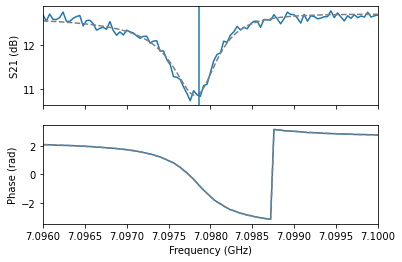

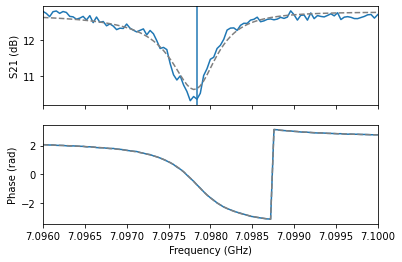

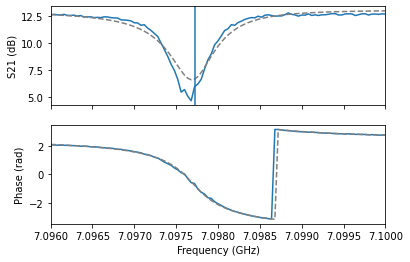

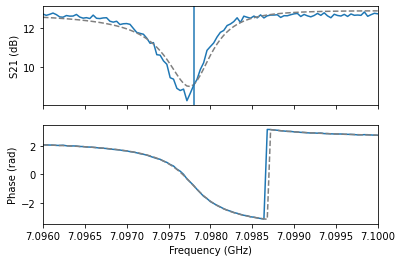

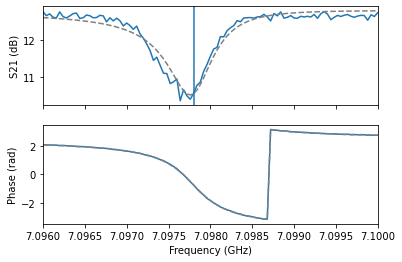

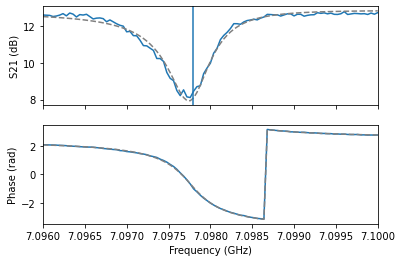

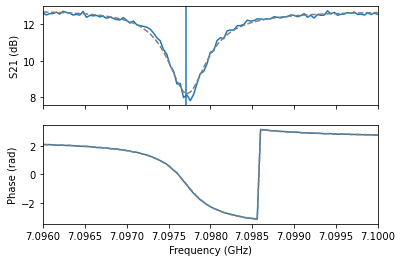

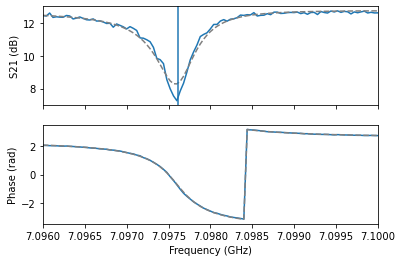

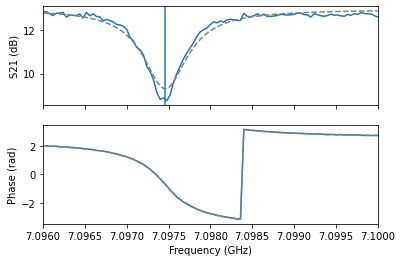

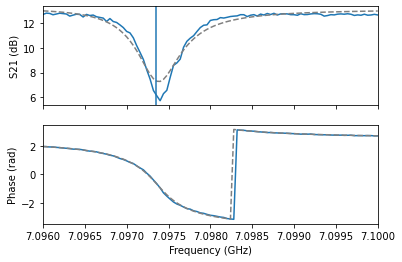

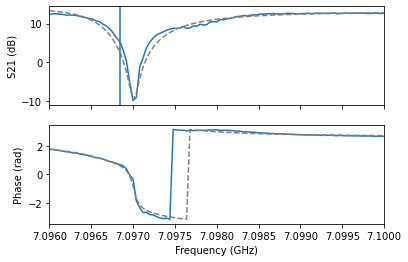

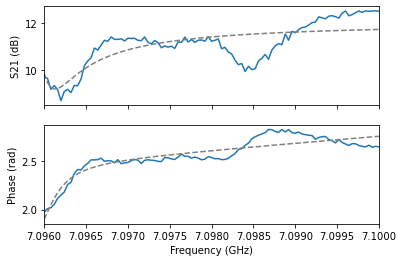

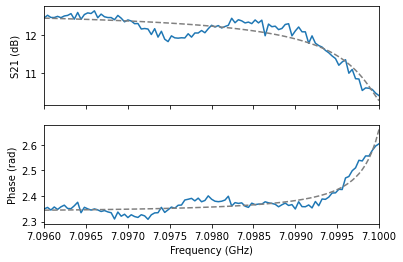

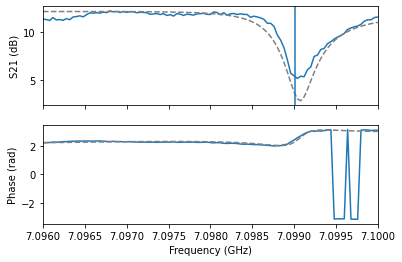

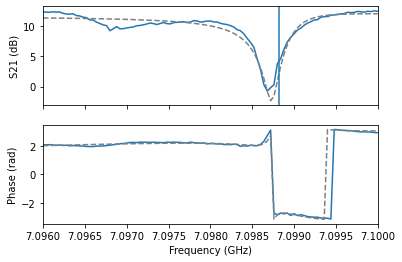

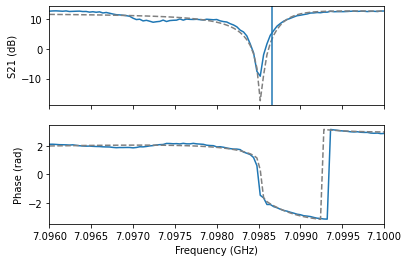

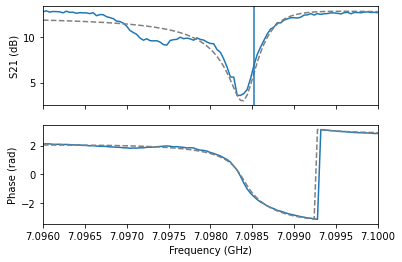

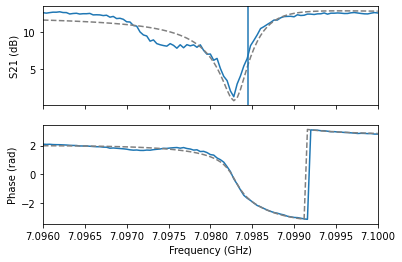

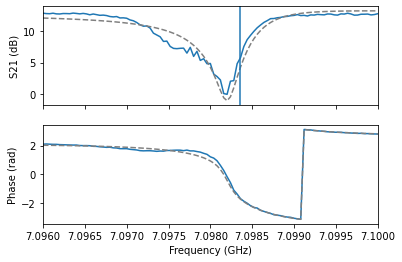

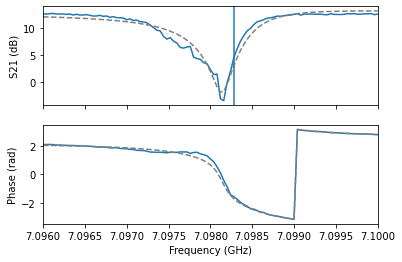

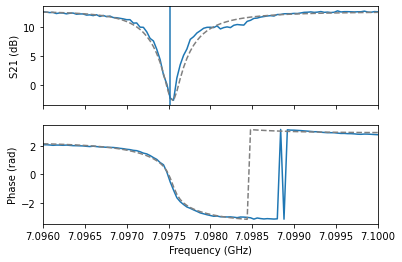

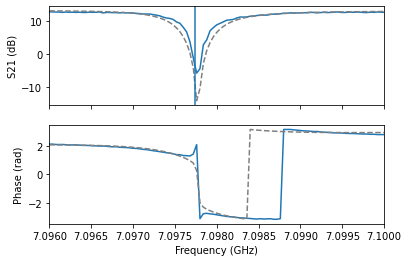

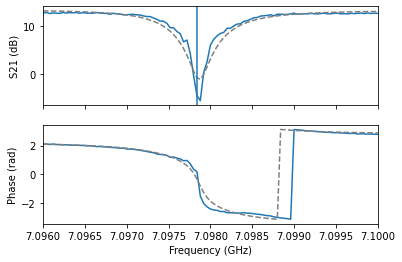

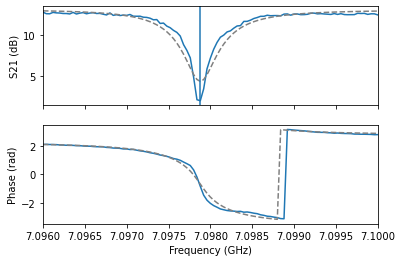

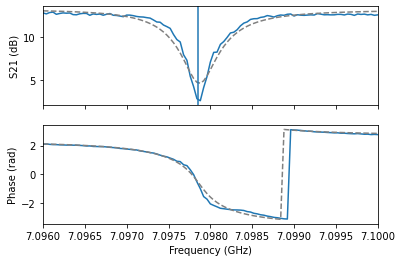

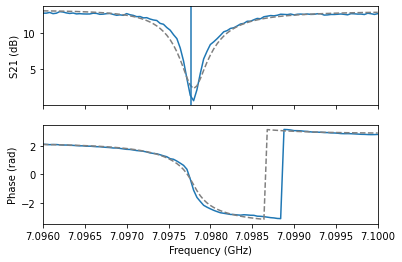

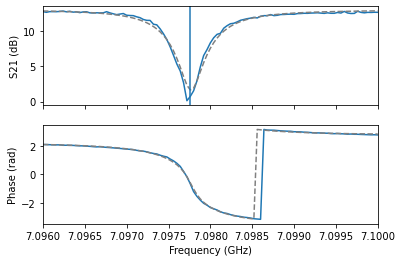

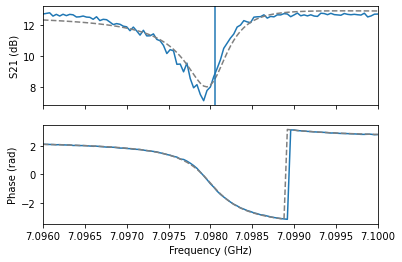

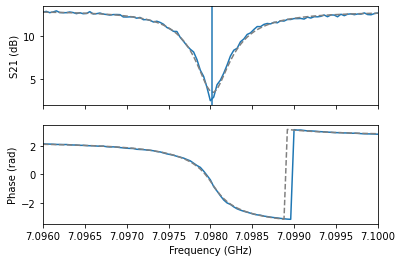

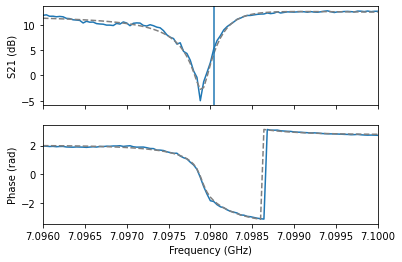

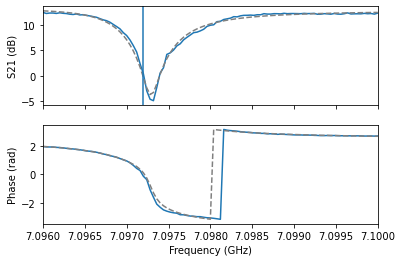

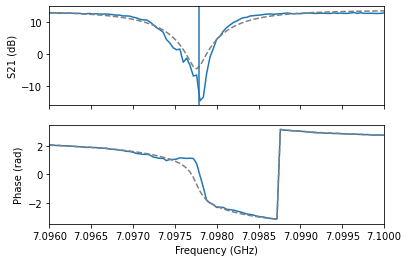

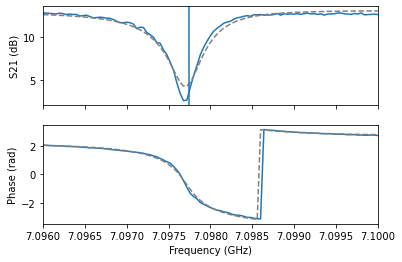

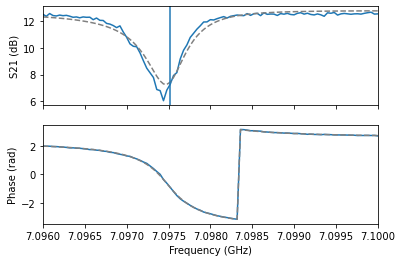

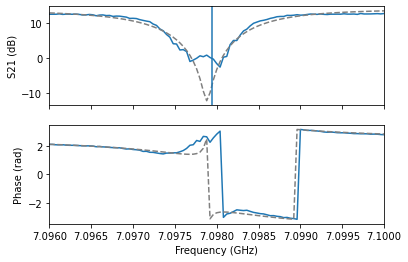

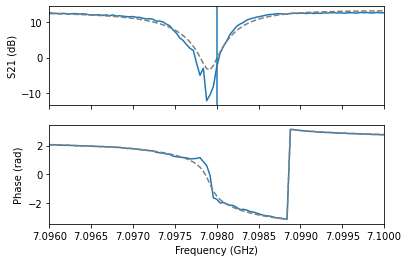

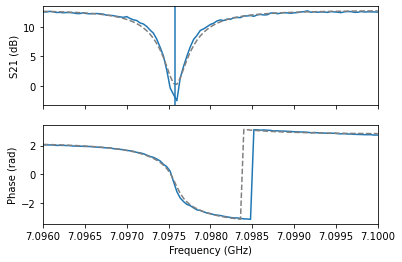

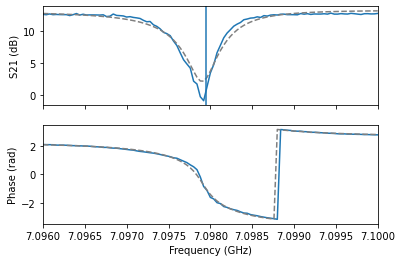

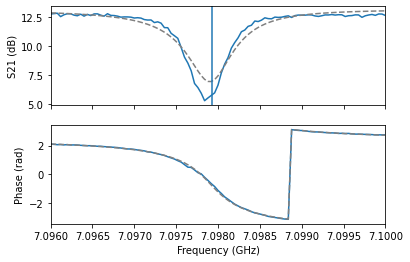

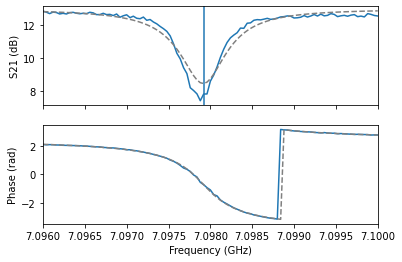

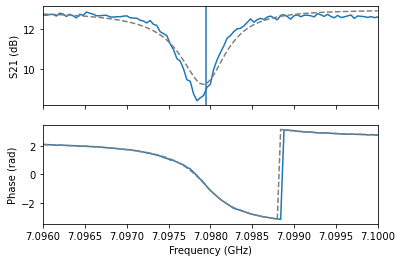

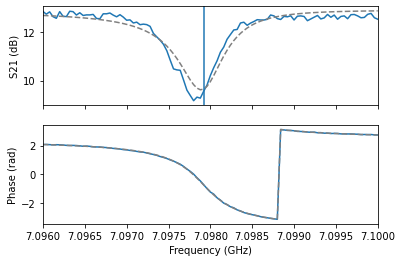

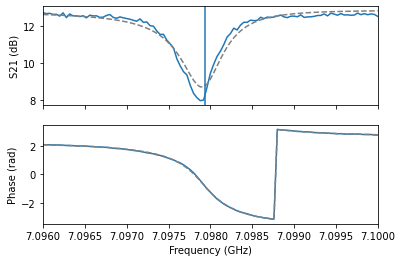

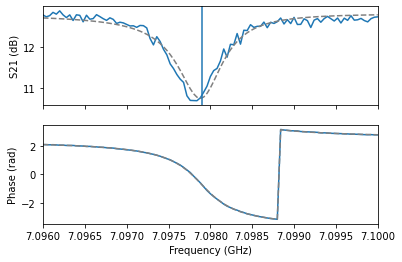

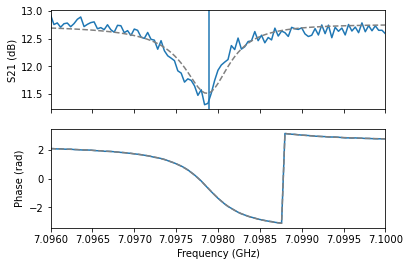

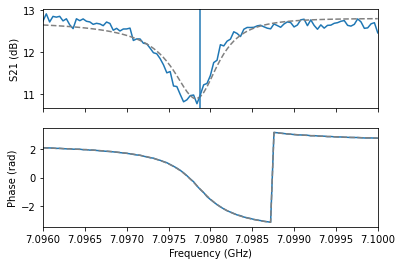

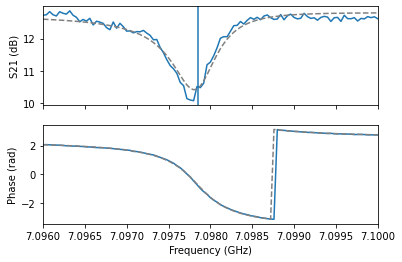

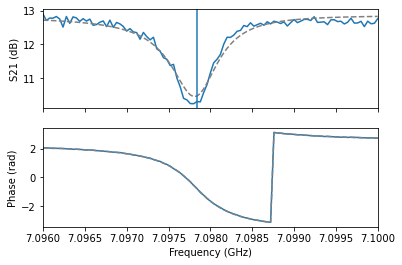

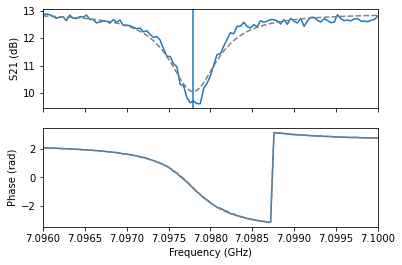

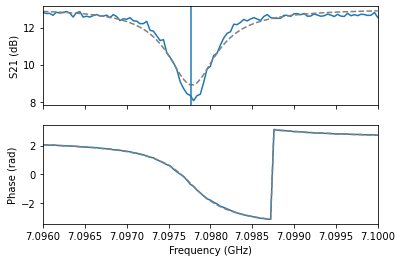

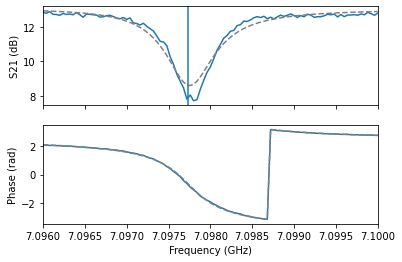

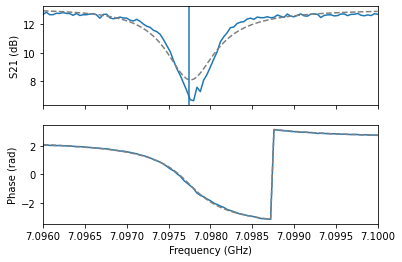

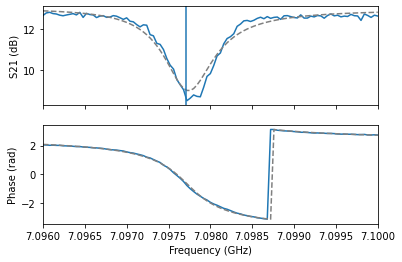

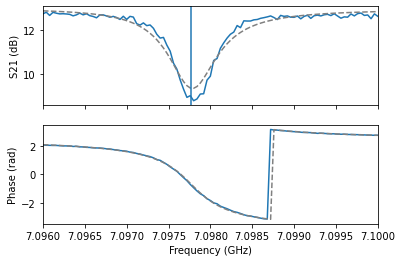

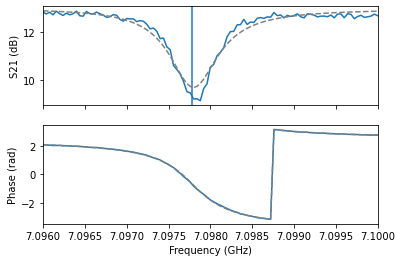

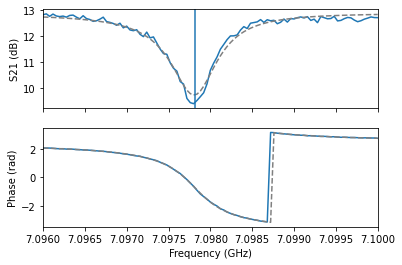

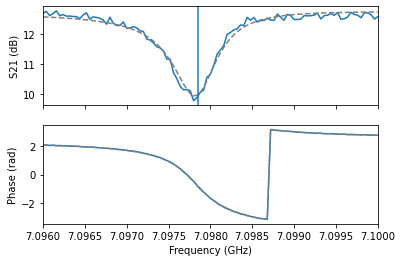

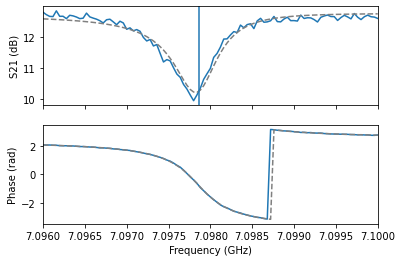

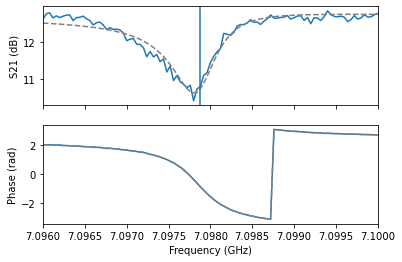

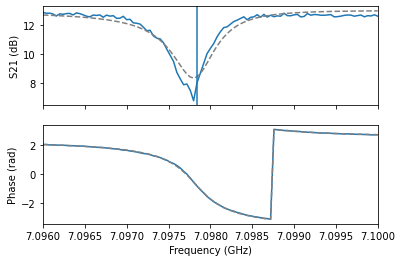

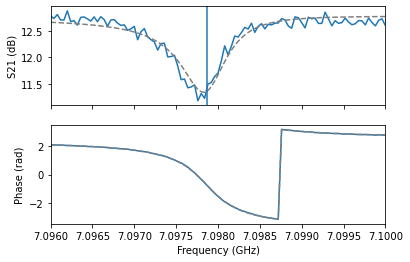

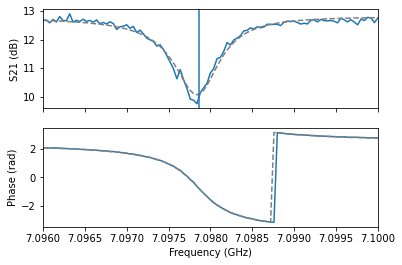

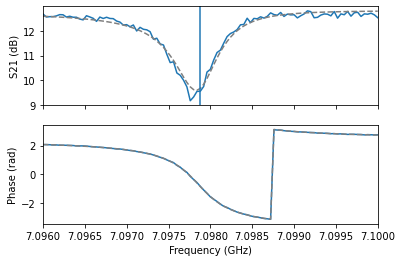

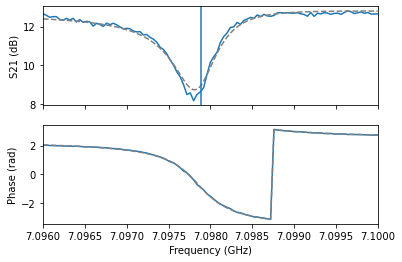

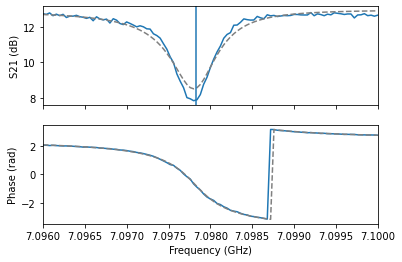

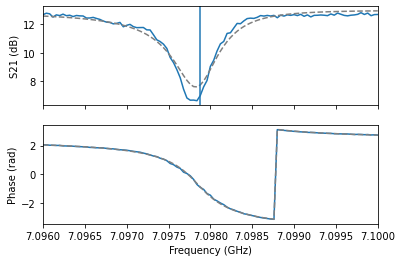

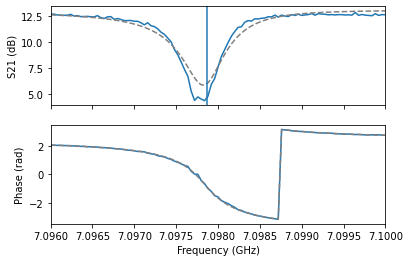

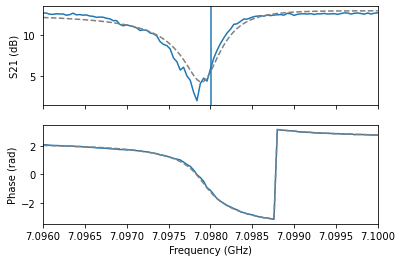

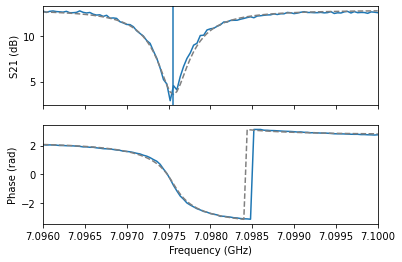

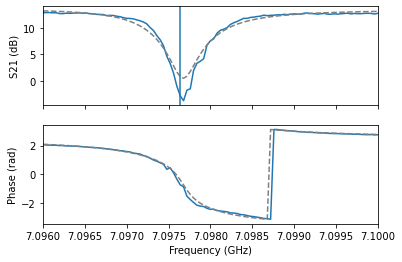

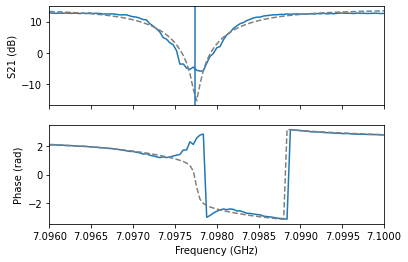

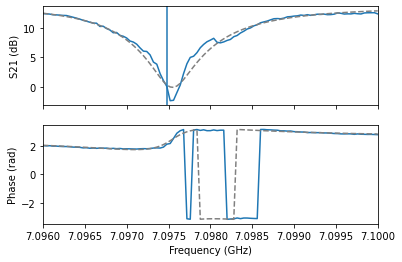

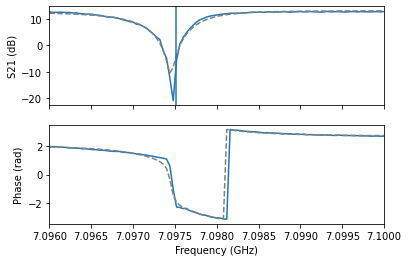

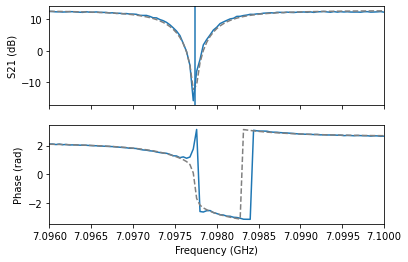

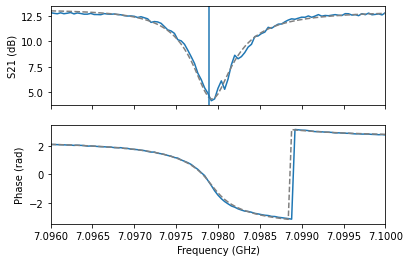

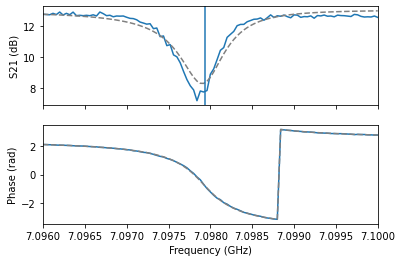

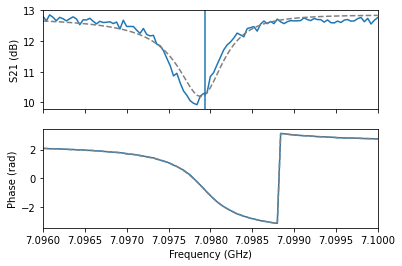

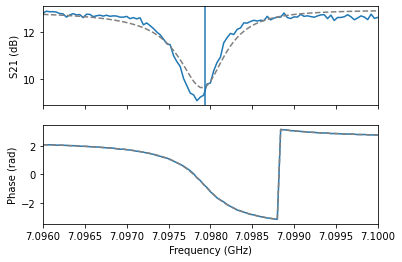

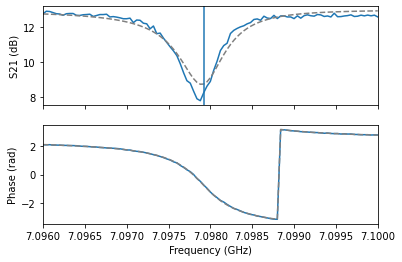

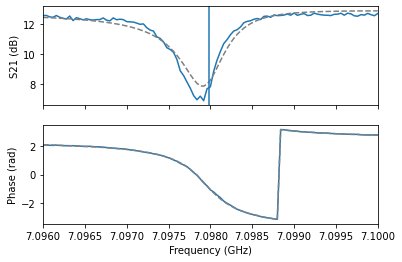

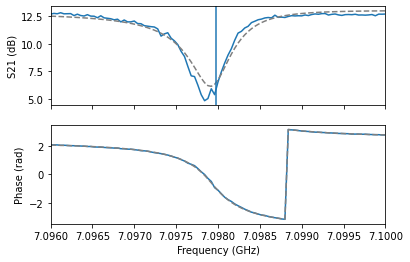

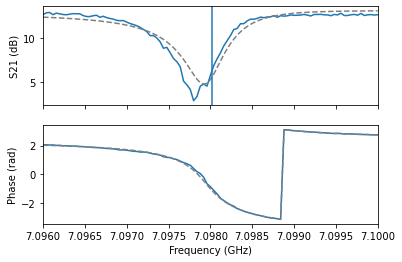

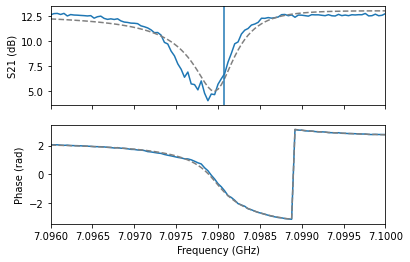

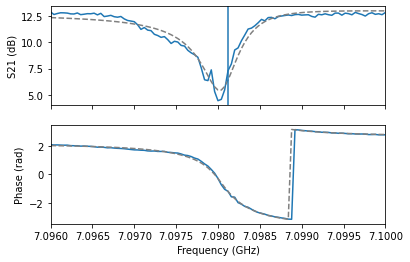

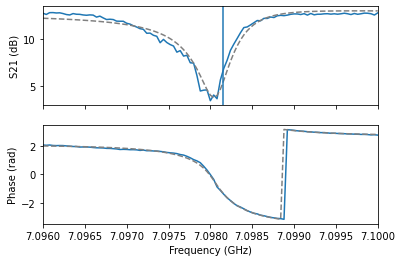

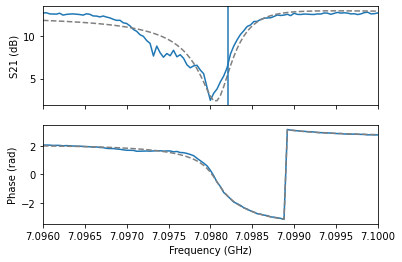

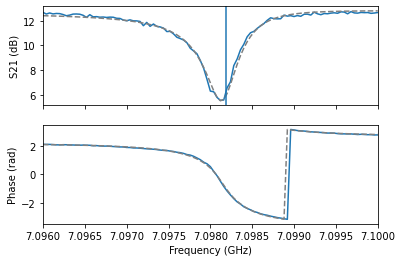

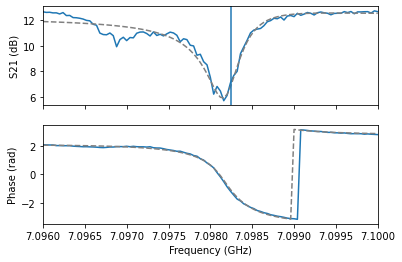

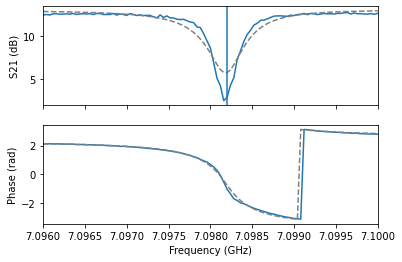

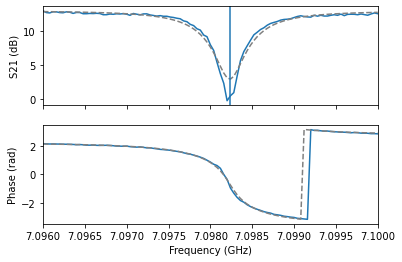

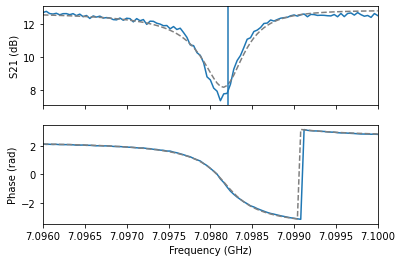

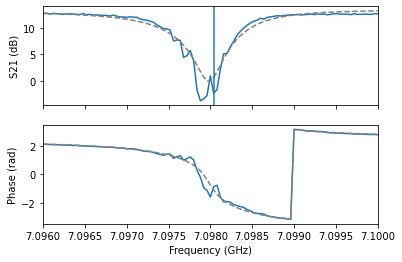

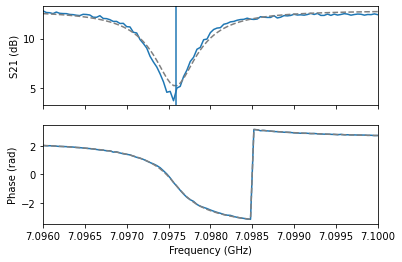

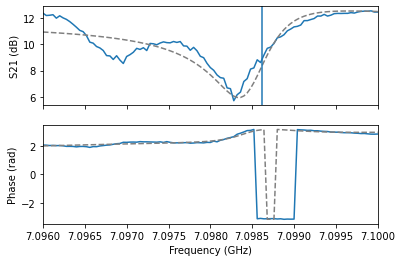

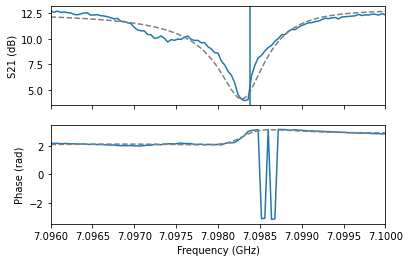

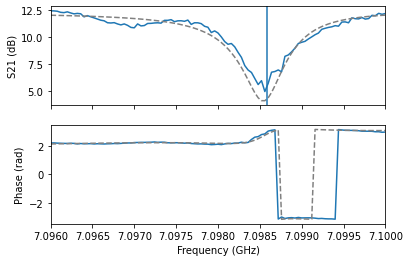

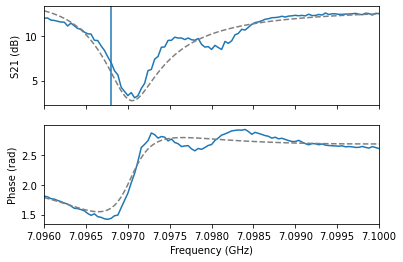

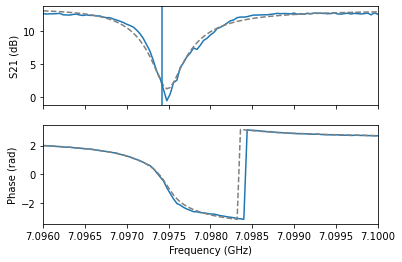

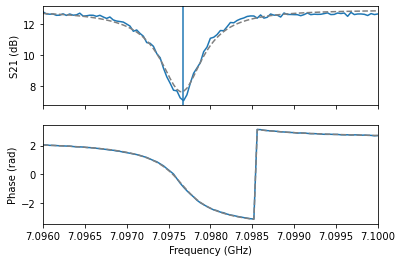

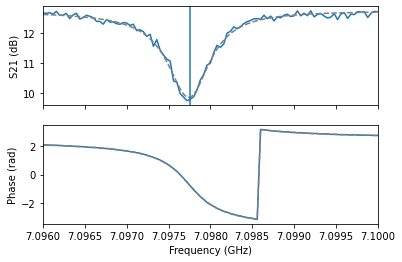

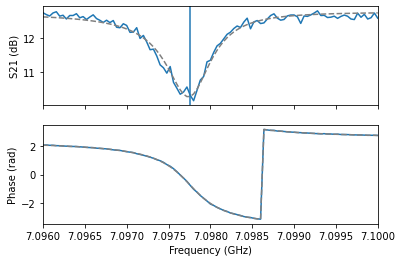

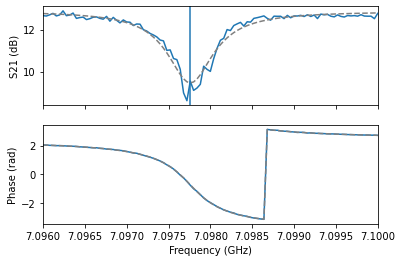

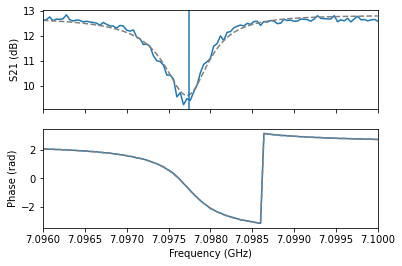

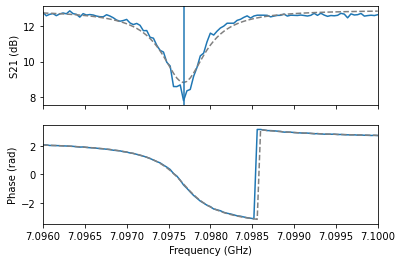

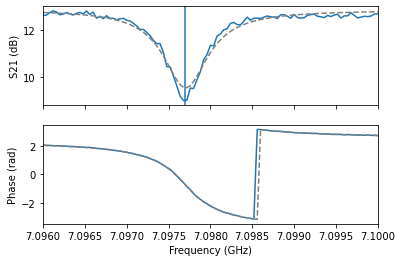

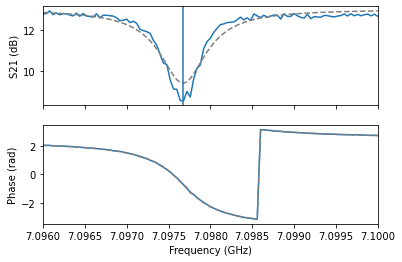

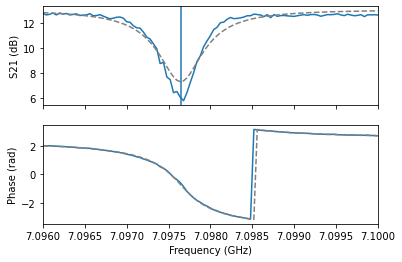

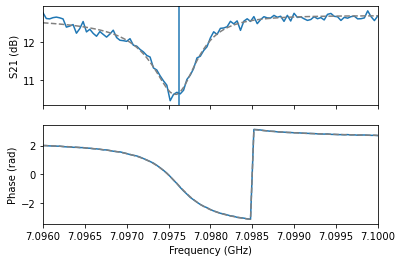

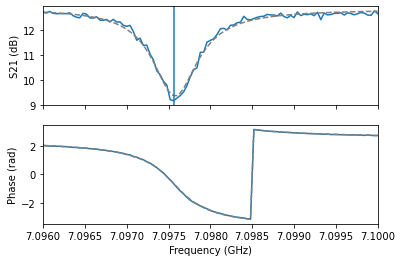

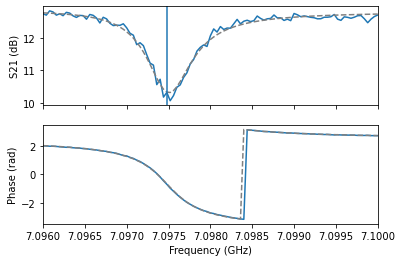

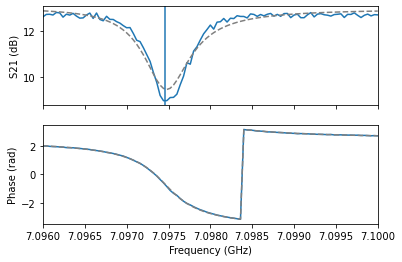

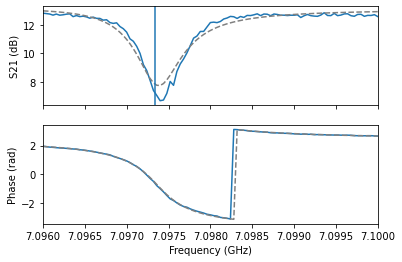

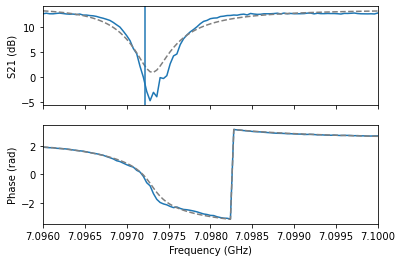

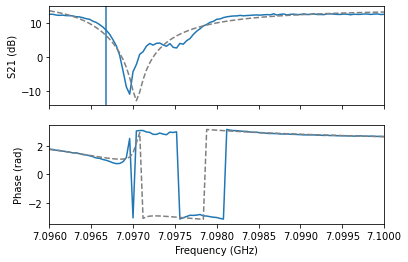

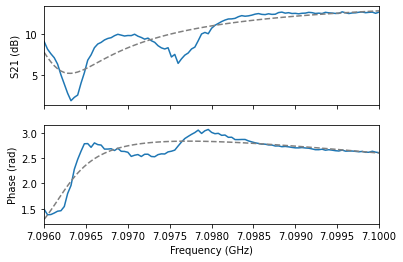

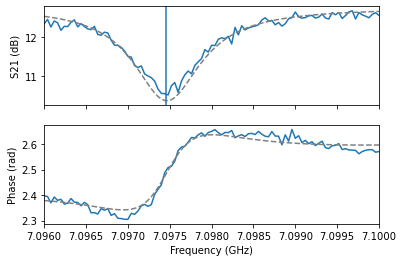

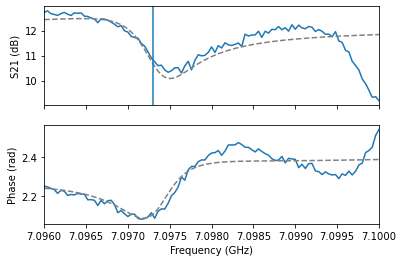

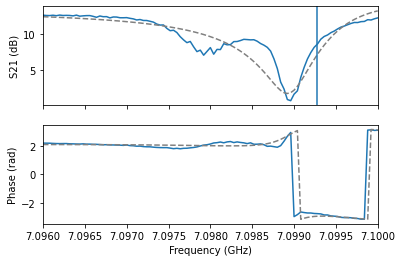

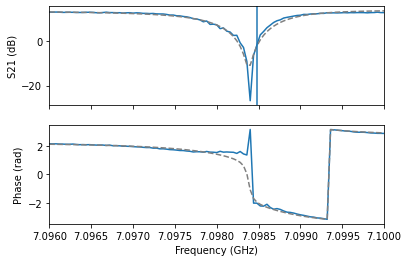

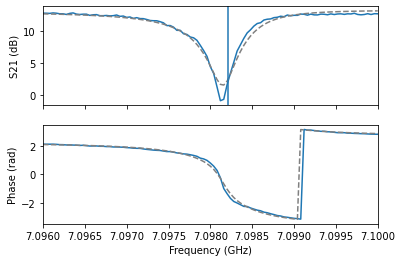

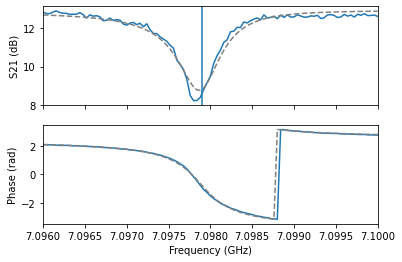

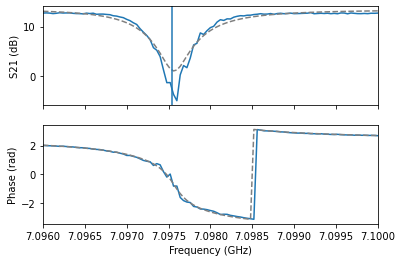

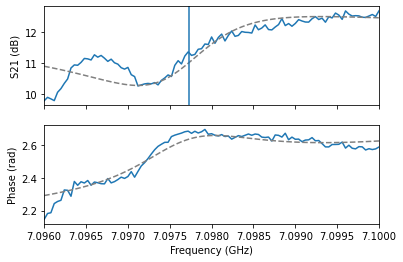

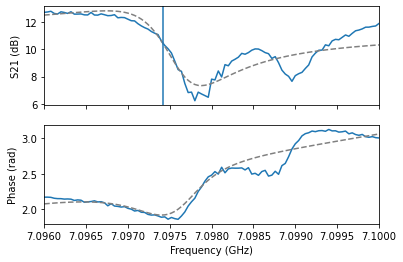

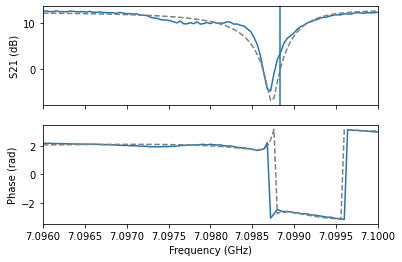

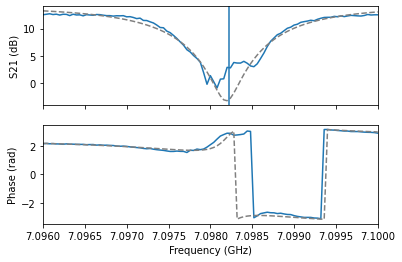

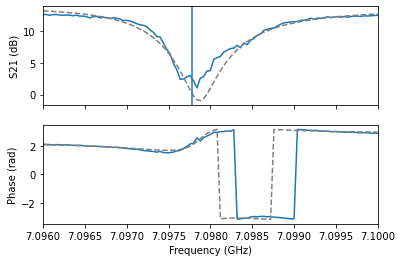

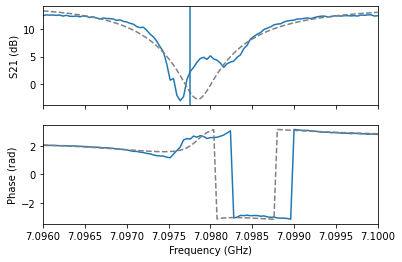

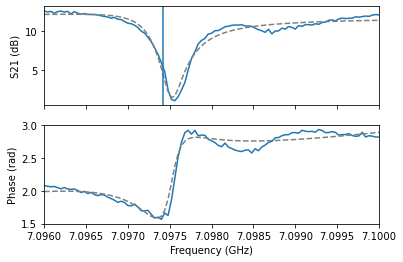

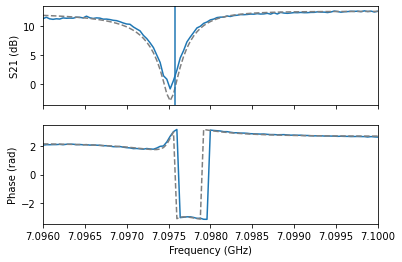

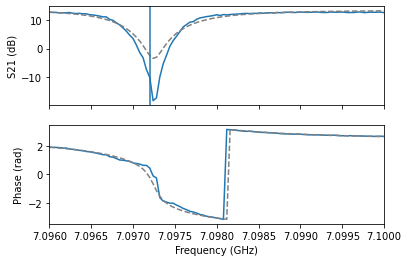

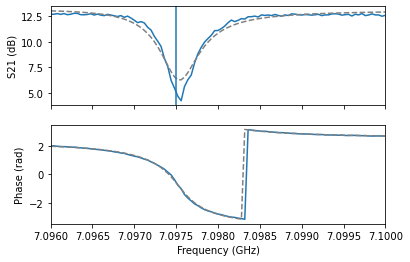

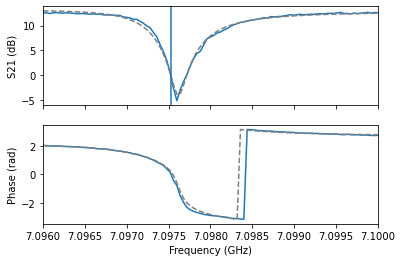

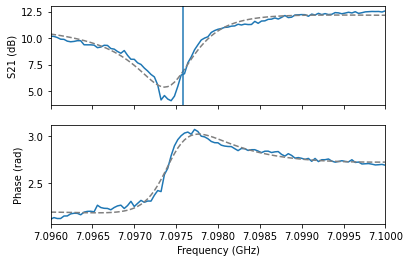

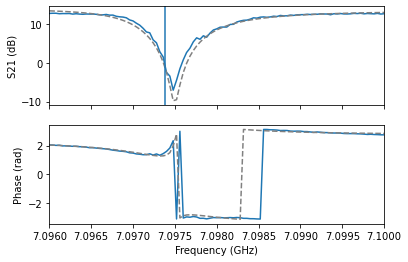

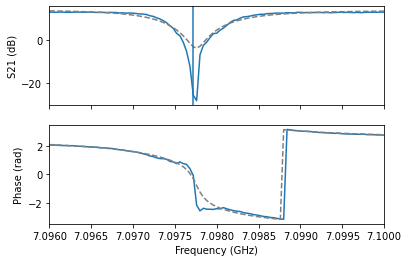

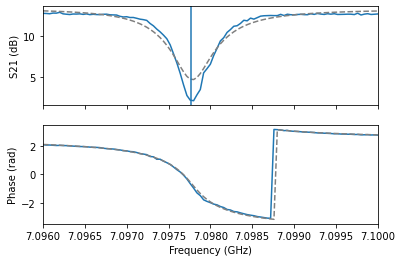

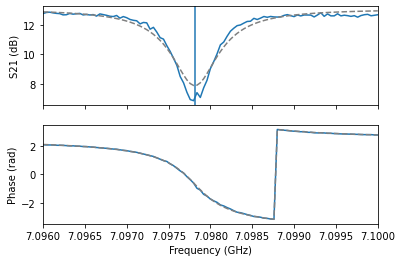

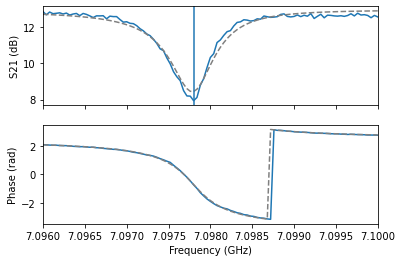

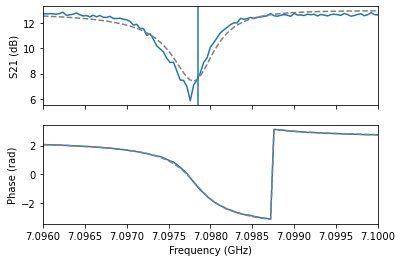

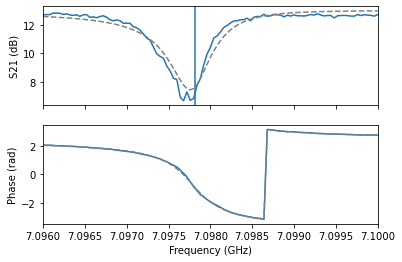

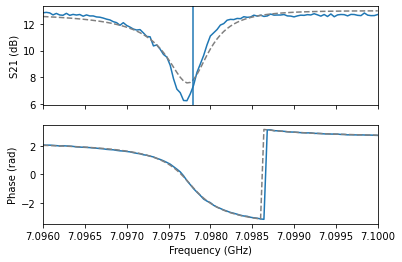

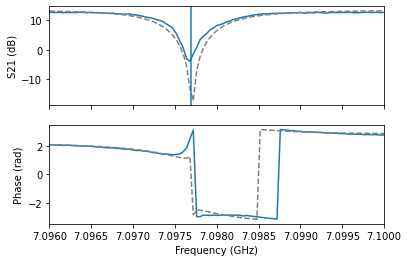

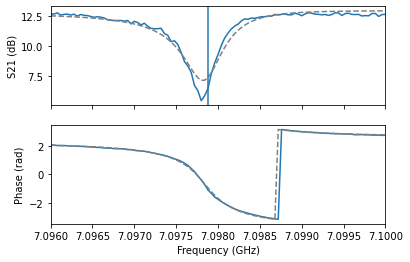

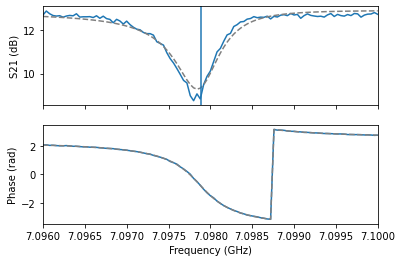

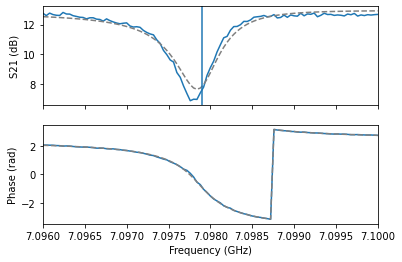

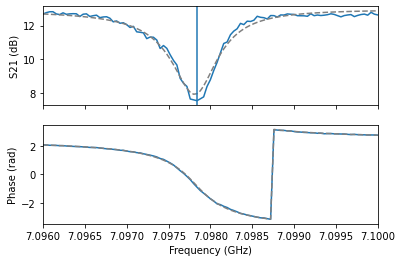

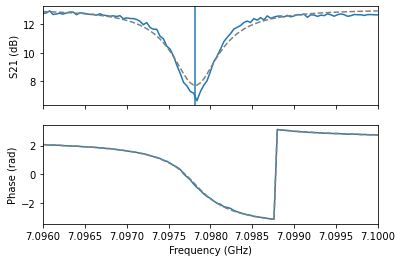

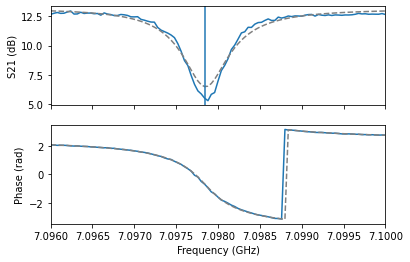

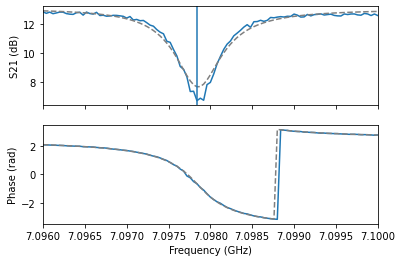

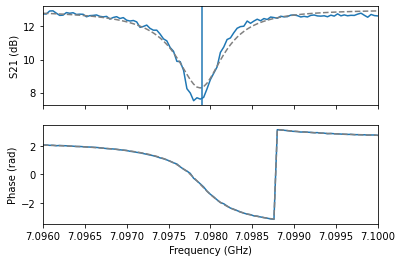

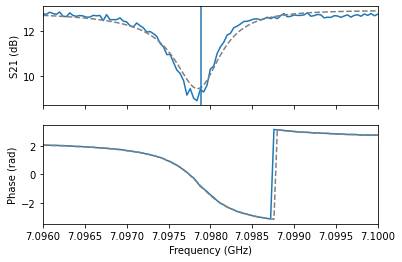

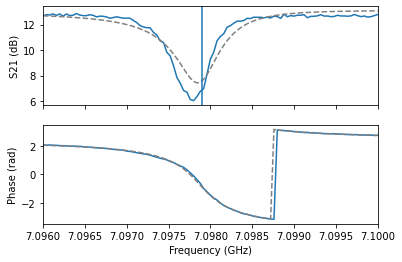

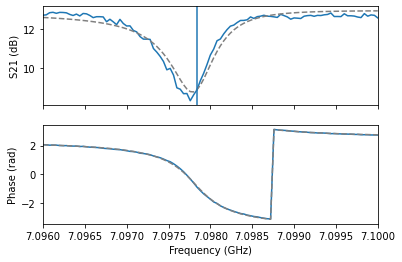

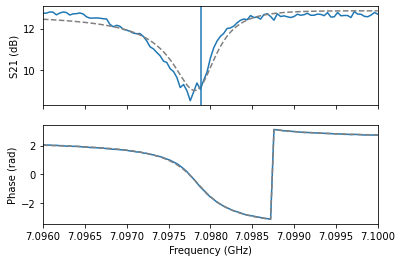

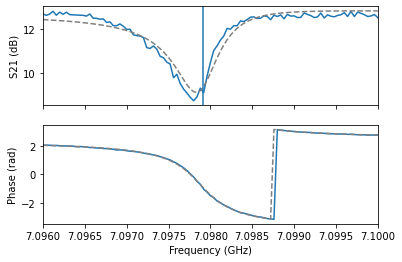

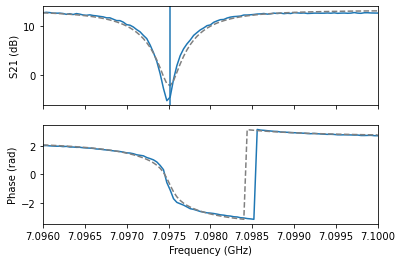

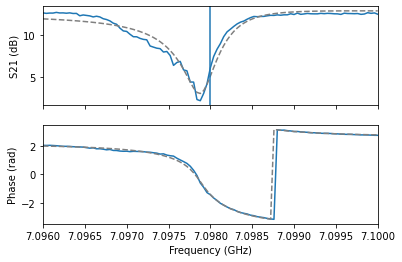

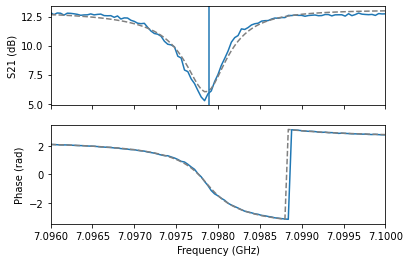

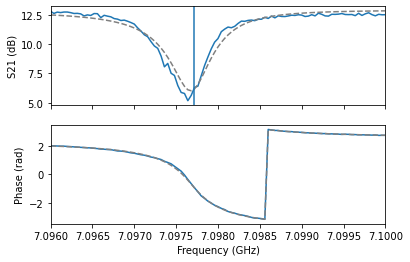

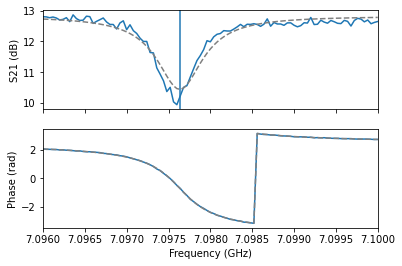

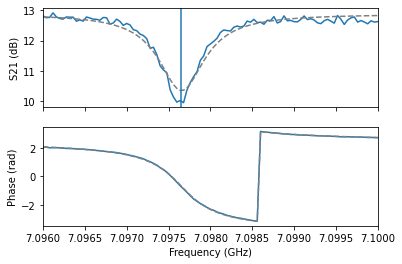

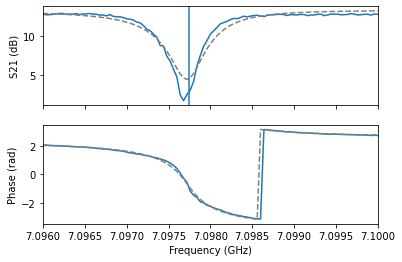

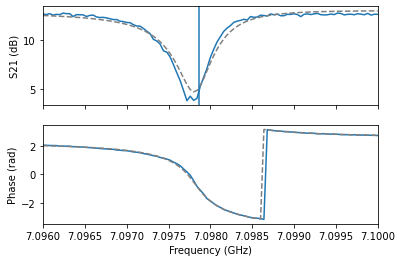

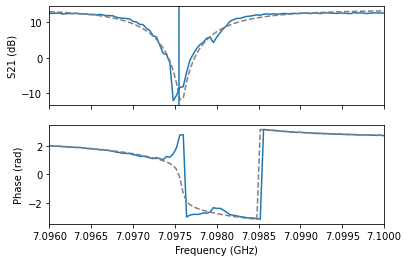

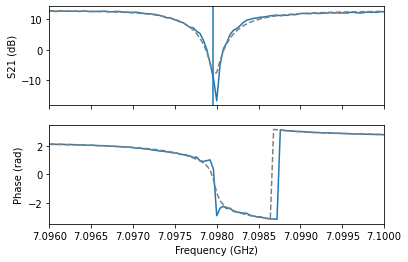

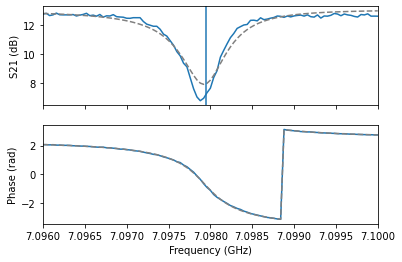

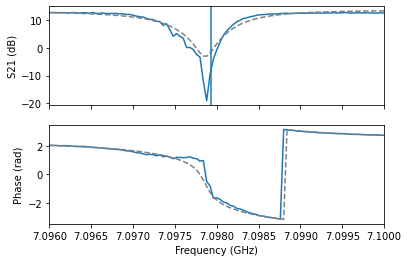

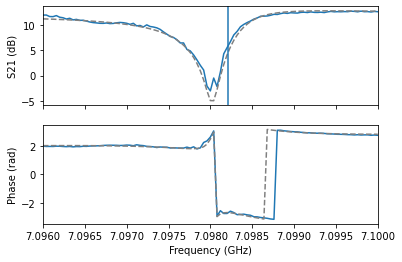

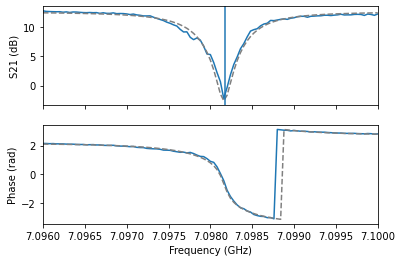

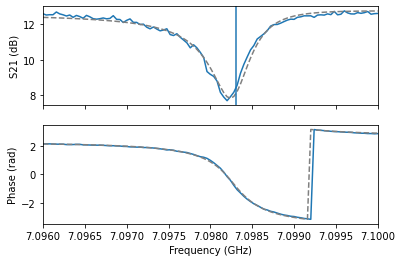

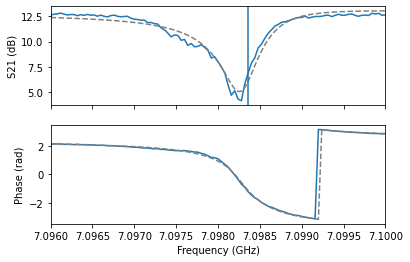

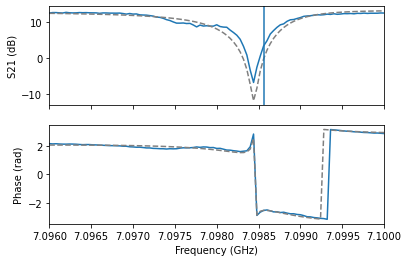

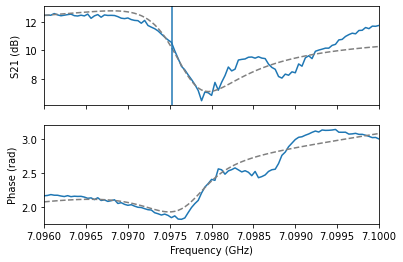

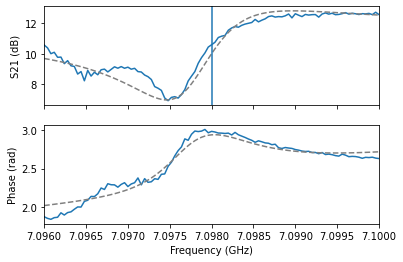

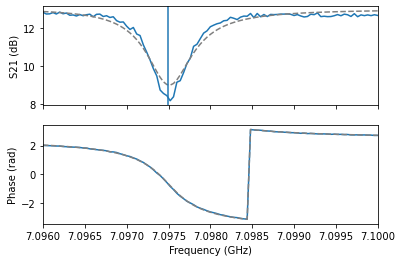

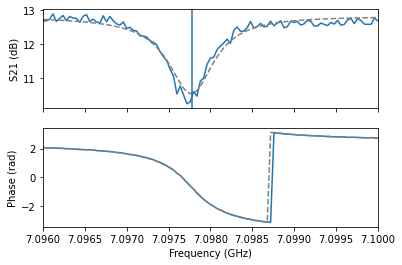

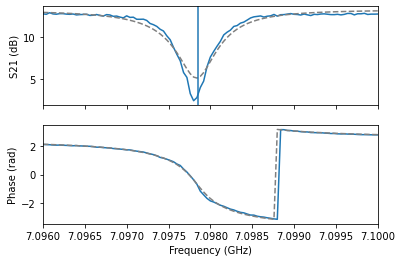

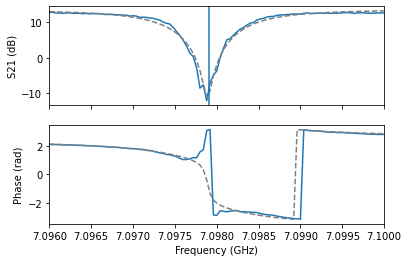

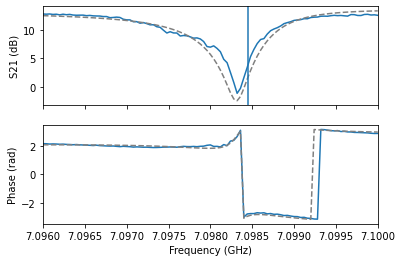

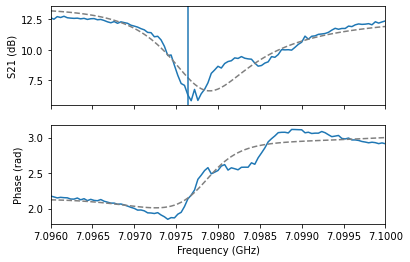

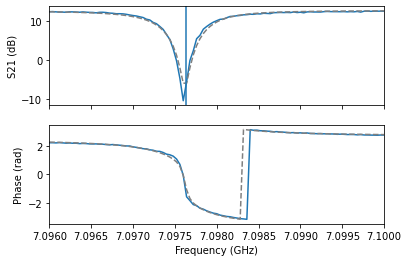

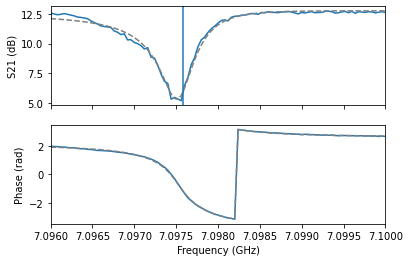

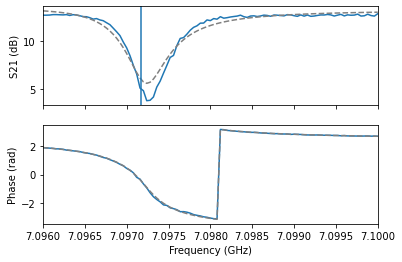

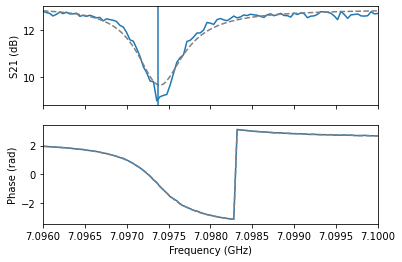

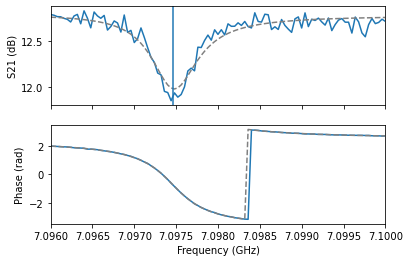

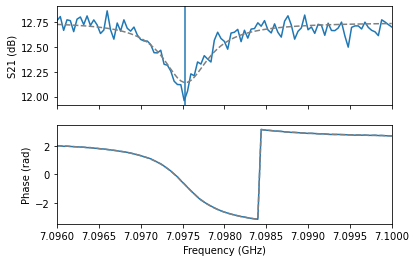

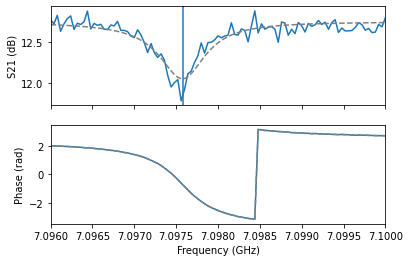

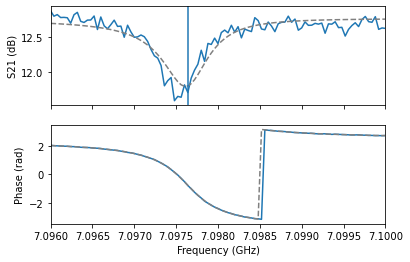

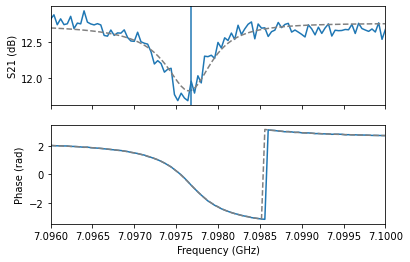

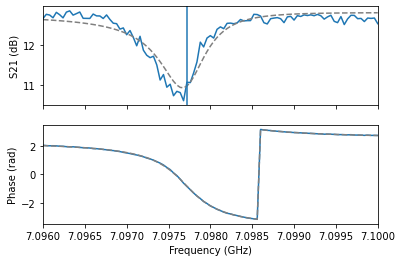

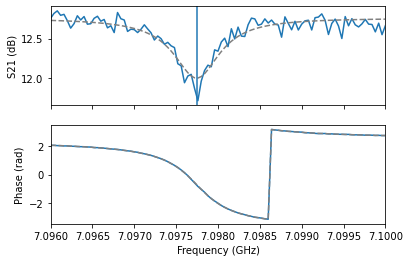

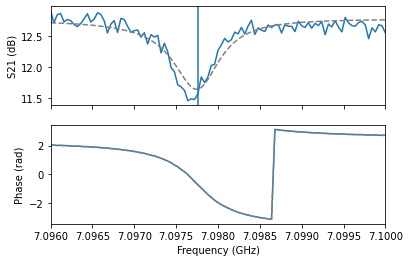

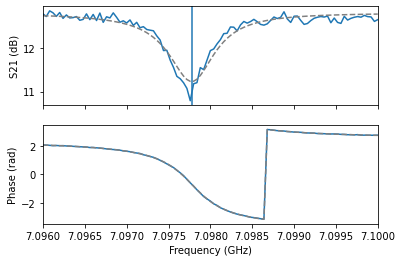

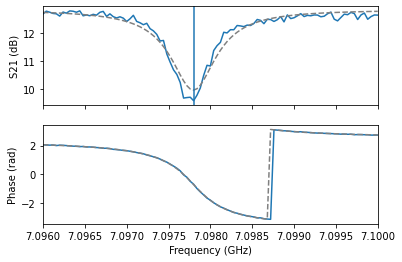

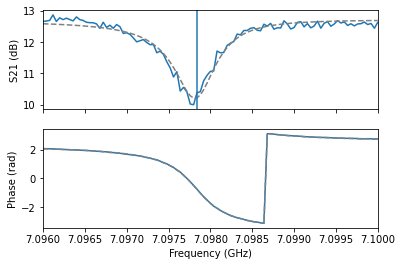

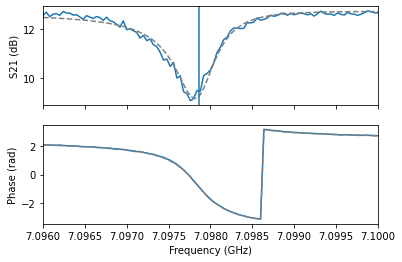

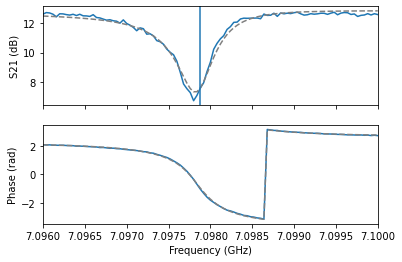

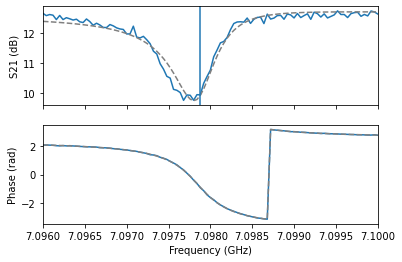

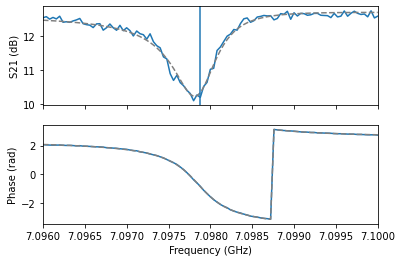

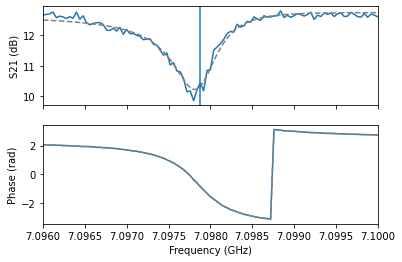

In [615]:
sweeps = []
res_freqs = []

for i, current_val in tqdm(enumerate(coil_currents)):
    print(f"Current is: coil:{current_val}, dc:{dc_currents[i]}" )
    # Set yoko
    yoko.on()
    yoko.ramp_current(current_val, step=coil_step, delay=0.3)
    # Set dc line yoko2
    yoko2.on()
    yoko2.ramp_current(dc_currents[i], step=dc_step, delay=0.3)
    time.sleep(3)
    
    ### Fit resonator
    vna.two_tone_mode(two_tone_port=3, mode=False, frequency = 7298958000.0)


    vna.start(start)
    vna.stop(stop)
    vna.port1.source_power(-50)
    vna.points(101)
    vna.averages(1)
    vna.if_bandwidth(10)


    fig, data = vna_trace(vna, run=True)

    params, cov, chi = resonator_regression(data.index.to_numpy(), data['I'] + 1j*data['Q'])


    # Reflection_fitting
    rparams = reflection_resonator_params(*params, covar=cov)
    smith = resonator_f_to_S(data.index.to_numpy(), *params)
    fig.axes[0].plot(data.index/1e9, 20*np.log10(np.abs(smith)), '--', color='gray')
    fig.axes[1].plot(data.index/1e9, np.angle(smith), '--', color='gray')

    fig.axes[0].axvline(rparams['f0']/1e9)
    res_freq = rparams['f0']/1e9
    print(f'Resonator frequency is: {res_freq} GHz')
    res_freqs.append(res_freq)
    
    
    
    ### Perform Two Tone       
    vna.two_tone_mode(two_tone_port=3, mode=True, frequency = rparams['f0'])
    vna.if_bandwidth(15)
    vna.points(two_tone_points)
    vna.start(two_tone_start)
    vna.stop(two_tone_end)
    vna.ports[2].source_power(two_tone_power)
    
    
    
    
    try:
        swp = vna_trace_no_fig(vna, run=True)
    except:
        try:
            print('Error')
            time.sleep(3)
            swp = vna_trace_no_fig(vna, run=False)
        except:
            print(f'Still error on {i}')

    sweeps += [swp]

name = f'2023-11-07_{device}_{qubit}-current_sweep_{two_tone_start}to{two_tone_end}GHz_{two_tone_power}dbm_c2p_line_1attenuators.csv'
data = pd.concat(sweeps, keys=coil_currents[:i+1], names=['Current'])
data.to_csv(datadir / name)
        

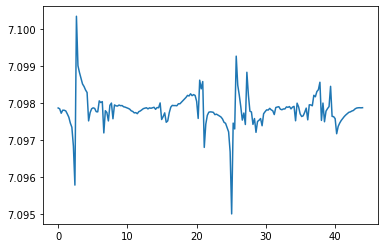

In [627]:
plt.plot(coil_currents*1e6, res_freqs)

In [652]:
res_freqs_data = pd.DataFrame(res_freqs)

In [654]:
res_freqs_data.to_csv(datadir / f'{device}_{qubit}_two_tone_res_freqs_2phi_regime.csv')

## Read CSV

In [169]:
name = '2023-11-07_cos2phi_v2_sep_style_light_c2p-current_sweep_200000000.0to7200000000.0GHz_20dbm.csv'

In [617]:
two_tone_sweep = pd.read_csv(datadir / name, index_col=[0, 1])


In [618]:
plotting_data_two_tone_sweep = two_tone_sweep['phase'].to_numpy().reshape((len(coil_currents), two_tone_points))

C:\Users\qnl\AppData\Local\Continuum\anaconda3\envs\parametric\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


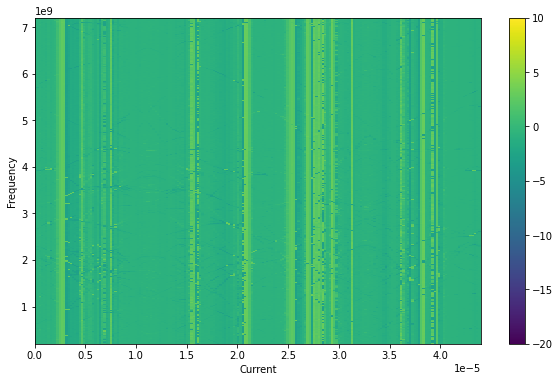

In [619]:
fig, ax = plt.subplots(figsize=(10,6))
im = ax.pcolormesh(coil_currents, np.linspace(two_tone_start, two_tone_end, two_tone_points),plotting_data_two_tone_sweep.transpose()
             , vmin=-20, vmax=10
             )
ax.set_xlabel('Current')
ax.set_ylabel('Frequency')

fig.colorbar(im)


### Better Visibility

In [628]:
plotting_data_two_tone_sweep = np.array(two_tone_sweep['phase']).reshape((len(coil_currents),two_tone_points))

In [629]:
better_data = []

for row in np.array(plotting_data_two_tone_sweep):
#     row = np.unwrap(row)
    new_row = (row-np.median(row))/ abs(np.median(row))
    better_data.append(new_row)
    
better_data = np.array(better_data)

C:\Users\qnl\AppData\Local\Continuum\anaconda3\envs\parametric\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


(0.0, 1000000000.0)

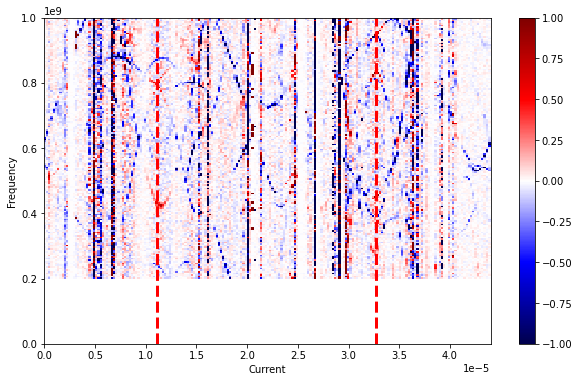

In [651]:
fig, ax = plt.subplots(figsize=(10,6))
im = ax.pcolormesh(coil_currents, np.linspace(.2*1e9, 7.2*1e9, two_tone_points), better_data.transpose(), cmap='seismic'
                   , vmin=-1, vmax=1
                  )
ax.set_xlabel('Current')
ax.set_ylabel('Frequency')
ax.axvline(11.1e-6, c='red', linestyle='--', linewidth=3)
ax.axvline(32.7e-6, c='red', linestyle='--', linewidth=3)
fig.colorbar(im)
ax.set_ylim([0,1e9])
# ax.set_ylim([7.2*1e9, 10.0*1e9])

In [650]:
dc_currents

array([2.00e-06, 5.00e-06, 8.00e-06, 1.10e-05, 1.40e-05, 1.70e-05,
       2.00e-05, 2.30e-05, 2.60e-05, 2.90e-05, 3.20e-05, 3.50e-05,
       3.80e-05, 4.10e-05, 4.40e-05, 4.70e-05, 5.00e-05, 5.30e-05,
       5.60e-05, 5.90e-05, 6.20e-05, 6.50e-05, 6.80e-05, 7.10e-05,
       7.40e-05, 7.70e-05, 8.00e-05, 8.30e-05, 8.60e-05, 8.90e-05,
       9.20e-05, 9.50e-05, 9.80e-05, 1.01e-04, 1.04e-04, 1.07e-04,
       1.10e-04, 1.13e-04, 1.16e-04, 1.19e-04, 1.22e-04, 1.25e-04,
       1.28e-04, 1.31e-04, 1.34e-04, 1.37e-04, 1.40e-04, 1.43e-04,
       1.46e-04, 1.49e-04, 1.52e-04, 1.55e-04, 1.58e-04, 1.61e-04,
       1.64e-04, 1.67e-04, 1.70e-04, 1.73e-04, 1.76e-04, 1.79e-04,
       1.82e-04, 1.85e-04, 1.88e-04, 1.91e-04, 1.94e-04, 1.97e-04,
       2.00e-04, 2.03e-04, 2.06e-04, 2.09e-04, 2.12e-04, 2.15e-04,
       2.18e-04, 2.21e-04, 2.24e-04, 2.27e-04, 2.30e-04, 2.33e-04,
       2.36e-04, 2.39e-04, 2.42e-04, 2.45e-04, 2.48e-04, 2.51e-04,
       2.54e-04, 2.57e-04, 2.60e-04, 2.63e-04, 2.66e-04, 2.69e